In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import geopandas as gpd
import math
from matplotlib.colors import TwoSlopeNorm, Normalize
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm
import json
import matplotlib.cm as cm
from tqdm import tqdm
from datetime import datetime
from matplotlib.patches import Patch
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.patches import FancyArrowPatch

today = datetime.today().strftime('%Y%m%d')
today

'20250801'

In [10]:
scout_result_date = '062725'

# 0. Load scout results

In [ ]:
ref = pd.read_csv(r'cost_table_operational\ref.json.csv')
AEO = pd.read_csv(r'cost_table_operational\aeo.json.csv')
state = pd.read_csv(r'cost_table_operational\state.json.csv')
fossil = pd.read_csv(r'cost_table_operational\fossil.json.csv')
brk = pd.read_csv(r'cost_table_operational\brk.json.csv')
accel = pd.read_csv(r'cost_table_operational\accel.json.csv')
# add sector and scenario
def extract_sector(df):
    df['sector'] = df['meas'].str.extract(r'\((R|C)\)')[0].map({'R': 'Residential', 'C': 'Commercial'})
    return df

ref = extract_sector(ref)
AEO = extract_sector(AEO)
state = extract_sector(state)
fossil = extract_sector(fossil)
brk = extract_sector(brk)
accel = extract_sector(accel)
ref['scenario'] = 'Reference'
AEO['scenario'] = 'AEO 2023 w/ BTB'
state['scenario'] = 'State and Local Action'
fossil['scenario'] = 'Fossil Favorable'
brk['scenario'] = 'Breakthrough'
accel['scenario'] = 'Accelerate'
cost_all_scenario = pd.concat([AEO, ref, state, fossil, brk, accel], ignore_index=True)

In [17]:
# add cost saving metric
baseline_cost = cost_all_scenario[cost_all_scenario['metric'].isin(['Baseline Energy Cost (USD)'])]
efficient_cost = cost_all_scenario[cost_all_scenario['metric'].isin(['Efficient Energy Cost (USD)'])]
# Merge on all identifying columns except 'metric' and 'value'
merge_keys = ['meas', 'adoption_scn', 'reg', 'bldg_type', 'end_use', 'fuel', 'year', 'sector', 'scenario']
merged_df  = pd.merge(
    baseline_cost,
    efficient_cost,
    on=merge_keys,
    suffixes=('_baseline', '_efficiency')
)
cost_saving = merged_df.copy()
cost_saving['value'] = cost_saving['value_baseline'] - cost_saving['value_efficiency']
cost_saving['metric'] = 'Cost Savings (USD)'
cost_saving = cost_saving[['meas', 'adoption_scn', 'metric','reg', 'bldg_type', 'end_use', 'fuel', 'year', 'value','sector', 'scenario']]
cost_saving.head(2)

meas            adoption_scn              metric reg  \
0  (R) Ref. Case Gas Dryer  Max adoption potential  Cost Savings (USD)  AL   
1  (R) Ref. Case Gas Dryer  Max adoption potential  Cost Savings (USD)  AL   

                                bldg_type end_use          fuel  year  value  \
0  Single Family/Manufactured Homes (New)   Other  Non-Electric  2024    0.0   
1  Single Family/Manufactured Homes (New)   Other  Non-Electric  2026    0.0   

        sector         scenario  
0  Residential  AEO 2023 w/ BTB  
1  Residential  AEO 2023 w/ BTB

In [18]:
cost_saving['end_use'].unique()

array(['Other', 'Heating (Equip.)', 'Cooling (Equip.)', 'Water Heating',
       'Cooking', 'Refrigeration', 'Ventilation',
       'Computers and Electronics', 'Lighting'], dtype=object)

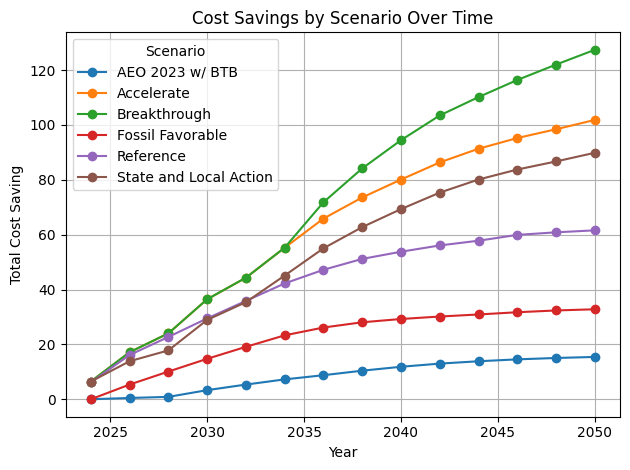

In [19]:
grouped_df = cost_saving.groupby(['scenario', 'year'])['value'].sum().reset_index()
grouped_df['value'] /= 1e9
# Step 2: Pivot for plotting
pivot_df = grouped_df.pivot(index='year', columns='scenario', values='value')

# Step 3: Plot
pivot_df.plot(marker='o')
plt.title('Cost Savings by Scenario Over Time')
plt.ylabel('Total Cost Saving')
plt.xlabel('Year')
plt.grid(True)
plt.legend(title='Scenario')
plt.tight_layout()
plt.show()

In [20]:
annual_cost_table = pd.concat([baseline_cost, efficient_cost, cost_saving], ignore_index=True)
annual_cost_table.head(2)

meas            adoption_scn  \
0  (R) Ref. Case Gas Dryer  Max adoption potential   
1  (R) Ref. Case Gas Dryer  Max adoption potential   

                       metric reg                               bldg_type  \
0  Baseline Energy Cost (USD)  AL  Single Family/Manufactured Homes (New)   
1  Baseline Energy Cost (USD)  AL  Single Family/Manufactured Homes (New)   

  end_use          fuel  year         value applicable_end_use       sector  \
0   Other  Non-Electric  2024  23341.573890              Other  Residential   
1   Other  Non-Electric  2026  68678.802592              Other  Residential   

          scenario  
0  AEO 2023 w/ BTB  
1  AEO 2023 w/ BTB

### check negative savings

In [110]:
annual_cost_table['scenario'].unique()

array(['AEO 2023 w/ BTB', 'Reference', 'State and Local Action',
       'Fossil Favorable', 'Breakthrough', 'Accelerate'], dtype=object)

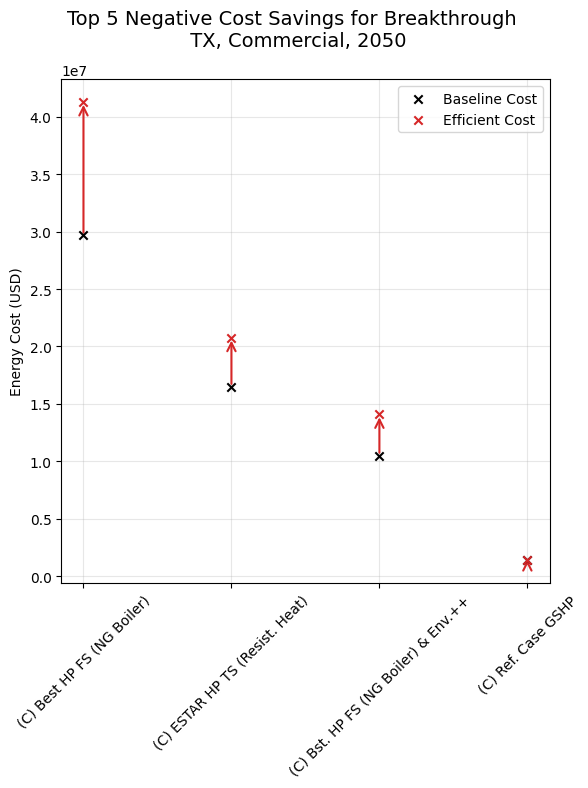

In [137]:
import matplotlib.pyplot as plt
import numpy as np
scenario = 'Breakthrough'
state = 'TX'
sector = 'Commercial'
state_df = annual_cost_table[annual_cost_table['reg']==state]
# Same filtering and prep as before
df_2050 = state_df[
    (state_df['reg'] == state) &
    (state_df['year'] == 2050) &
    (state_df['sector'] == sector) & 
    (state_df['scenario'] == scenario)

]

pivot_df = df_2050.pivot_table(
    index='meas',
    columns='metric',
    values='value',
    aggfunc='sum'
).reset_index()

# Define columns
savings_col = 'Cost Savings (USD)'
baseline_col = 'Baseline Energy Cost (USD)'
efficiency_col = 'Efficient Energy Cost (USD)'

required_cols = [baseline_col, efficiency_col, savings_col]
for col in required_cols:
    if col not in pivot_df.columns:
        raise ValueError(f"Missing expected column: {col}")

pivot_df = pivot_df[pivot_df[savings_col] < 0]
pivot_df = pivot_df.reindex(
    pivot_df[savings_col].abs().sort_values(ascending=False).head(5).index
)

# Set up plot
labels = pivot_df['meas']
x = np.arange(len(labels))

fig, ax = plt.subplots(figsize=(6,8))

# Plot baseline and efficient cost as scatter points
ax.scatter(x, pivot_df[baseline_col], color='black', label='Baseline Cost', zorder=3, marker='x')
ax.scatter(x, pivot_df[efficiency_col], color='tab:red', label='Efficient Cost', zorder=3, marker='x')

# Plot vertical arrows showing savings from baseline to efficient
for i, (baseline, efficient) in enumerate(zip(pivot_df[baseline_col], pivot_df[efficiency_col])):
    ax.annotate(
        '',
        xy=(x[i], efficient),     # Arrow tip (Efficient)
        xytext=(x[i], baseline),  # Arrow tail (Baseline)
        arrowprops=dict(arrowstyle='->', color='tab:red', linewidth=1.5, mutation_scale=15),
        zorder=2
    )
    # Annotate cost savings amount at the midpoint
    mid = (baseline + efficient) / 2
    saving = pivot_df.iloc[i][savings_col]
    # ax.annotate(
    #     f"{saving:,.0f}",
    #     xy=(x[i], mid),
    #     xytext=(0, 0),
    #     textcoords="offset points",
    #     ha='center',
    #     fontsize=9,
    #     color='tomato'
    # )

# Axis setup
ax.set_ylabel('Energy Cost (USD)')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
# ax.axhline(0, color='gray', linestyle='--', linewidth=0.8)
ax.grid(alpha=0.3)
# Title and legend
title = f'Top 5 Negative Cost Savings for {scenario} \n {state}, {sector}, 2050'
fig.suptitle(title, fontsize=14)
# Create proxy artists
# baseline_proxy = mlines.Line2D([], [], color='black', marker='x', linestyle='None', label='Baseline Cost')
# efficient_proxy = mlines.Line2D([], [], color='tab:red', marker='x', linestyle='None', label='Efficient Cost')
# # arrow_proxy = mlines.Line2D([], [], color='tab:red', marker='>', linestyle='-', 
# #                            markersize=8, linewidth=1.5, label='Baseline → Efficient')

# # Option 2: Alternative with different arrow marker
# arrow_proxy = mlines.Line2D([], [], color='tab:red', marker='CARETRIGHTBASE', linestyle='-', 
#                            markersize=10, linewidth=1.5, label='Baseline → Efficient')

# ax.legend(handles=[baseline_proxy, efficient_proxy, arrow_proxy])
ax.legend()
plt.tight_layout()
plt.savefig(f'Top 5 Negative Cost Savings for {scenario} {state}, {sector}, 2050', bbox_inches='tight')


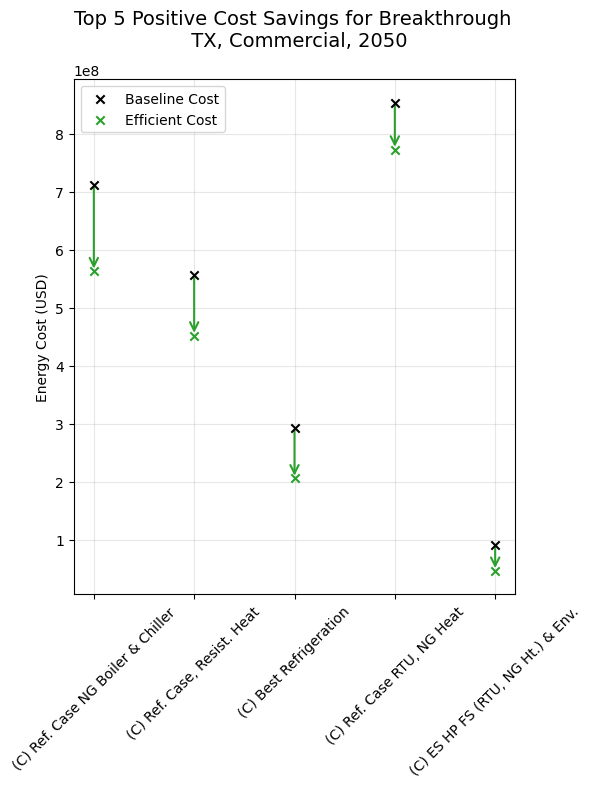

In [120]:
pivot_df = df_2050.pivot_table(
    index='meas',
    columns='metric',
    values='value',
    aggfunc='sum'
).reset_index()

# Define columns
savings_col = 'Cost Savings (USD)'
baseline_col = 'Baseline Energy Cost (USD)'
efficiency_col = 'Efficient Energy Cost (USD)'

required_cols = [baseline_col, efficiency_col, savings_col]
for col in required_cols:
    if col not in pivot_df.columns:
        raise ValueError(f"Missing expected column: {col}")

pivot_df = pivot_df[pivot_df[savings_col] > 0]
pivot_df = pivot_df.reindex(
    pivot_df[savings_col].abs().sort_values(ascending=False).head(5).index
)

# Set up plot
labels = pivot_df['meas']
x = np.arange(len(labels))

fig, ax = plt.subplots(figsize=(6,8))

# Plot baseline and efficient cost as scatter points
ax.scatter(x, pivot_df[baseline_col], color='black', label='Baseline Cost', zorder=3,marker='x')
ax.scatter(x, pivot_df[efficiency_col], color='tab:green', label='Efficient Cost', zorder=3,marker='x')

# Plot vertical arrows showing savings from baseline to efficient
for i, (baseline, efficient) in enumerate(zip(pivot_df[baseline_col], pivot_df[efficiency_col])):
    ax.annotate(
        '',
        xy=(x[i], efficient),     # Arrow tip (Efficient)
        xytext=(x[i], baseline),  # Arrow tail (Baseline)
        arrowprops=dict(arrowstyle='->', color='tab:green', linewidth=1.5, mutation_scale=15),
        zorder=2
    )
    # Annotate cost savings amount at the midpoint
    mid = (baseline + efficient) / 2
    saving = pivot_df.iloc[i][savings_col]
    # ax.annotate(
    #     f"{saving:,.0f}",
    #     xy=(x[i], mid),
    #     xytext=(0, 0),
    #     textcoords="offset points",
    #     ha='center',
    #     fontsize=9,
    #     color='tomato'
    # )

# Axis setup
ax.set_ylabel('Energy Cost (USD)')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
# ax.axhline(0, color='gray', linestyle='--', linewidth=0.8)
ax.grid(alpha=0.3)
# Title and legend
title = f'Top 5 Positive Cost Savings for {scenario} \n {state}, {sector}, 2050'
fig.suptitle(title, fontsize=14)
ax.legend()
plt.tight_layout()
plt.savefig(f'Top 5 Positive Cost Savings for {scenario}, {state}, {sector}, 2050', bbox_inches='tight')


# 1. Line plots for 3 cost metrics

In [9]:
annual_cost_table_grouped = (annual_cost_table.groupby(['year', 'scenario','metric'])['value'].sum().reset_index())
annual_cost_table_grouped.head(2)

year         scenario                      metric         value
0  2024  AEO 2023 w/ BTB  Baseline Energy Cost (USD)  5.645939e+11
1  2024  AEO 2023 w/ BTB          Cost Savings (USD) -1.382828e-05

In [18]:
# extract AEO baseline for efficiency cost
# AEO_baseline = annual_cost_table_grouped[
#     (annual_cost_table_grouped['metric'] == 'Baseline Energy Cost (USD)') &
#     (annual_cost_table_grouped['scenario'] == 'AEO')
# ].copy()

# AEO_baseline['scenario'] = 'AEO 2023 Baseline'
# AEO_baseline['metric'] = 'Efficient Energy Cost (USD)'

In [10]:
# ----------------------------------------------- #
# ------------ CHANGE METRICS HERE -------------- # 
# ----------------------------------------------- #

# metric_to_plot = 'Baseline Energy Cost (USD)'
metric_to_plot = 'Cost Savings (USD)' 
# metric_to_plot = 'Efficient Energy Cost (USD)'
sub_table = annual_cost_table_grouped[annual_cost_table_grouped['metric']==metric_to_plot]
if metric_to_plot == 'Efficient Energy Cost (USD)':
    sub_table = pd.concat([sub_table, AEO_baseline], ignore_index=True)
pivot = sub_table.pivot_table(
    index='year',
    columns=['scenario'],
    values='value'
)
pivot = pivot/1e9
pivot.head(2)

scenario  AEO 2023 w/ BTB  Accelerate  Breakthrough  Fossil Favorable  \
year                                                                    
2024        -1.382828e-14    6.466900      6.470800      1.445133e-13   
2026         4.688321e-01   17.147962     17.153935      5.362856e+00   

scenario  Reference  State and Local Action  
year                                         
2024       6.210404                6.458878  
2026      16.132921               13.872514

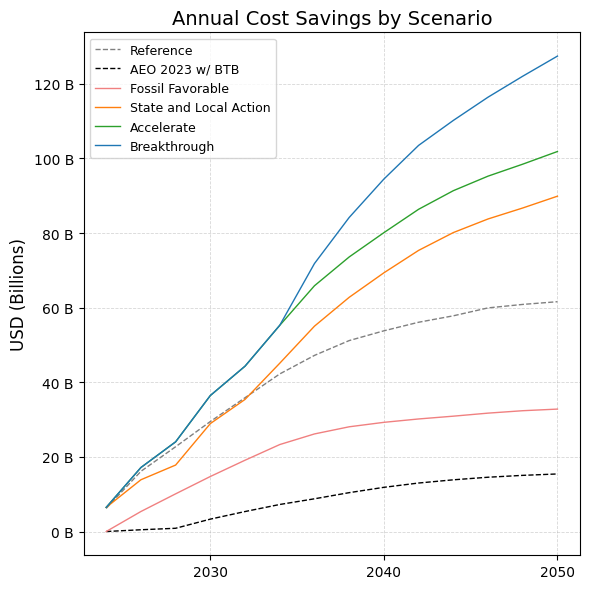

In [ ]:
# Define fixed colors for each scenario
# CHANGE HERE if scenario changes for customized colors
scenario_colors = {
    'Reference':'grey',
    'AEO 2023 w/ BTB':'black',
    # 'AEO 2023 Baseline': 'red',
    'Fossil Favorable': 'lightcoral',
    'State and Local Action': 'tab:orange',
    'Accelerate': 'tab:green',
    'Breakthrough': 'tab:blue',
}
pivot = pivot.reindex(columns=list(scenario_colors.keys()))
pivot

fig, ax = plt.subplots(figsize=(6,6))
for scenario in pivot.columns:    
    color = scenario_colors[scenario]
    linestyle = '--' if scenario.lower() in ['reference', 'aeo 2023 w/ btb'] else '-'
    linewidth = 2 if scenario == 'AEO 2023 Baseline' else 1
    ax.plot(
        pivot.index,
        pivot[scenario],
        label=scenario,
        color=color,
        linewidth=linewidth,
        linestyle=linestyle
    )
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, title='', fontsize=9)
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x:,.0f} B'))
ax.grid(visible=True, linestyle='--', linewidth=0.6, alpha=0.5)
ax.set_xticks([y for y in pivot.index if y % 5 == 0 and y >= 2025])
ax.set_ylabel("USD (Billions)", fontsize=12)

metric_for_title = metric_to_plot.replace(' (USD)', '')
title = f"Annual {metric_for_title} by Scenario"
# if metric_to_plot =='Cost Savings (USD)':
#     title = f"Energy Cost Savings vs. AEO 2023" 
ax.set_title(title, fontsize=14)
plt.tight_layout()
plt.savefig(f'cost_graph_operational/{title}_{today}.png', transparent=False, bbox_inches='tight')

# 2. Stack plot for cost savings by measures

## 2.1 breakdown by sector 

In [21]:
cost_saving['scenario'].unique()

array(['AEO 2023 w/ BTB', 'Reference', 'State and Local Action',
       'Fossil Favorable', 'Breakthrough', 'Accelerate'], dtype=object)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_stacked_area_for_all_sectors(df, state, prefix, ymin, ymax):

    # CHANGE HERE if scenario changes
    scenarios = ['AEO 2023 w/ BTB', 'Fossil Favorable', 'Reference', 'State and Local Action', 'Accelerate', 'Breakthrough']
    res_color = 'tab:orange'  #  orange 
    com_color = 'tab:blue'  #  blue

    fig, axes = plt.subplots(3, 2, figsize=(12, 10), sharex=True)
    axes = axes.flatten()

    skipped_total = 0  # To accumulate skipped negative values

    for i, scenario in enumerate(scenarios):
        ax = axes[i]

        if state == 'All States':
            sub_df = df[df['scenario'] == scenario]  # no state filtering
        else:
            sub_df = df[(df['scenario'] == scenario) & (df['reg'] == state)]

        if sub_df.empty:
            ax.set_title(f"{scenario}\n(No Data)")
            ax.axis('off')
            continue

        # Group and pivot
        pivot_df = sub_df.groupby(['year', 'sector'])['value'].sum().unstack(fill_value=0)
        # pivot_df = sub_df.groupby(['year'])['value'].sum()
        pivot_df /= 1e9  # Convert to billions
        pivot_df = pivot_df.sort_index()
        if scenario =='Fossil':
            pivot_df_save = pivot_df
        
        desired_order = [ 'Commercial', 'Residential']
        pivot_df = pivot_df[desired_order]
        # pivot_df.plot(ax=ax, kind='line', color=[com_color, res_color], linewidth=2, legend=False)
        # pivot_df.plot(ax=ax, kind='line', color='black', linewidth=2, legend=False)
        # Sum the two columns into one
        pivot_df['Total'] = pivot_df['Commercial'] + pivot_df['Residential']
        
        pivot_df[['Commercial']].plot(
            ax=ax,
            kind='line',
            linewidth=1.5,
            color=[com_color],
            legend=False  # or False, depending on your preference
        )
        
        # Now plot total on top for emphasis
        pivot_df['Total'].plot(ax=ax, color='tab:orange', linewidth=2, label='Total')
        # Fill area below Commercial
        ax.fill_between(pivot_df.index, 0, pivot_df['Commercial'], color='tab:blue', alpha=0.5, label='Commercial Area')
        
        # Fill area between Commercial and Total (i.e., Residential contribution)
        ax.fill_between(pivot_df.index, pivot_df['Commercial'], pivot_df['Total'], color='tab:orange', alpha=0.5, label='Residential Area')

        ax.set_ylim(ymin, ymax)

        # Final touches
        ax.axhline(0, color='black', linewidth=1)
        ax.grid(linestyle='--',alpha=0.5)
        ax.set_title(scenario)
        ax.set_ylabel(f"{prefix} ($B)")
        ax.set_xlim(2024, 2050)
        ax.set_xticks(np.arange(2025, 2051, 5))
        ax.set_xticklabels([str(year) for year in range(2025, 2051, 5)])
        ax.set_xlabel("Year")

    
    # Shared legend
    legend_handles = [
        Patch(facecolor=res_color, edgecolor=res_color, linewidth=1.5, label='Residential', alpha=0.5),
        Patch(facecolor=com_color, edgecolor=com_color, linewidth=1.5, label='Commercial', alpha=0.5)
    ]
    fig.legend(handles=legend_handles, loc='lower center', ncol=2, title='Sector')
    
    fig.suptitle(f"{prefix} by Scenario, {state}", fontsize=16)
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.savefig(f'cost_graph_operational/{prefix} {state}.png',transparent=False, bbox_inches='tight')
    # plt.close()
    return sub_df, pivot_df

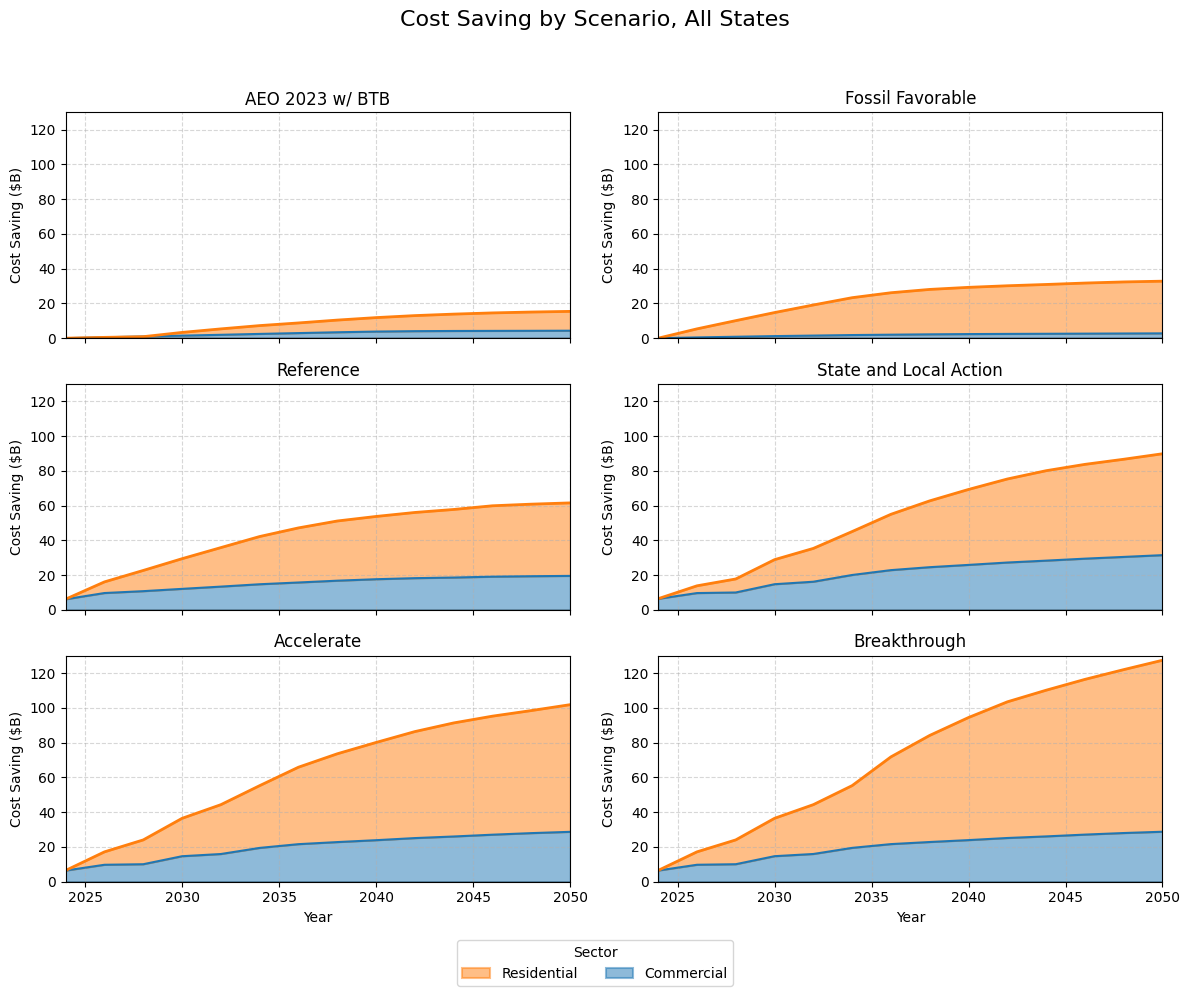

In [16]:
# scenario option: 'Reference', 'AEO', 'State Policies', 'Fossil', 'Breakthrough', 'Accelerate'

df_to_plot = cost_saving
# df_to_plot = efficient_cost

state = 'All States' 
ymax=130
# state = 'CA' 
# ymax = 25

# CHANGE HERE if scenario changes
scenarios = ['Reference', 'Fossil', 'Breakthrough']
if df_to_plot is cost_saving:
    prefix = 'Cost Saving'
elif df_to_plot is efficient_cost:
    prefix = 'Efficient Cost'
sub_df, pivot_df = plot_stacked_area_for_all_sectors(df_to_plot, state, prefix, ymin=0, ymax=ymax)

## 2.2 breakdown by measures

In [ ]:
def plot_stacked_cost_savings(df,ymin, ymax, color_map):
    bar_width = 0.6
    sub_df = df[df['year'].isin([2030, 2040, 2050])].copy()

    if sub_df.empty:
        print("No data for given state and scenario.")
        return

    pivot_df = sub_df.pivot_table(
        index='year',
        columns='meas',
        values='value',
        aggfunc='sum'
    ).fillna(0)
    pivot_df /= 1e9
    meas_totals = pivot_df.sum()
    top_n = 9
    sorted_measures = meas_totals.abs().sort_values(ascending=False)
    plotted_measures = sorted_measures.head(top_n).index.tolist()
    plotted_measures_set.update(plotted_measures)
    
    other_measures = sorted_measures.index.difference(plotted_measures)
    
    # Create an "Other" column by summing everything else
    pivot_df['All other measures'] = pivot_df[other_measures].sum(axis=1)
    
    # CHANGE HERE
    # Use categorical colormap directly (if plotting less than 20 measures)
    # cmap = plt.get_cmap('tab20')
    # cmap_index = 0
    # for meas in plotted_measures:
    #     if meas not in color_map:
    #         color_map[meas] = mcolors.to_hex(cmap(cmap_index % cmap.N))
    #         cmap_index += 1
    # color_map['All other measures'] = 'lightgrey'
    
    # Sample from rainbow colormap (if plotting less than 20 measures)
    cmap = plt.get_cmap('rainbow')
    n_colors = len(plotted_measures_set) # 3 scneraios x 9 measures
    
    for i, meas in enumerate(plotted_measures):
        if meas not in color_map:
            color_map[meas] = mcolors.to_hex(cmap(i / max(n_colors - 1, 1)))  # Normalize to [0, 1]
    color_map['All other measures'] = 'lightgrey'

    final_measures = plotted_measures + ['All other measures']
    color_list = [color_map[meas] for meas in final_measures]

    
    # Plot
    fig, ax = plt.subplots(figsize=(5,7))

    # Stacked positive
    pivot_df = pivot_df[final_measures]
    pivot_df.plot(kind='bar', stacked=True, ax=ax, legend=False, color=color_list, width=bar_width, alpha=0.8)

    # Label total on top
    totals = pivot_df.sum(axis=1)
    
    # Find highest and lowest values (positive or negative)
    max_year = totals.idxmax()
    min_year = totals.idxmin()
    
    max_val = totals[max_year]
    min_val = totals[min_year]
    
    print(f"Highest total cost savings: ${max_val:,.2f}B in {max_year}")
    print(f"Lowest total cost savings (most negative): ${min_val:,.2f}B in {min_year}")

    for i, (year, total) in enumerate(totals.items()):
        label = f"${total:,.2f}B"
        # label = (
        #     f"${total/1e9:,.0f}B" if abs(total) > 1e9 
        #     else f"${total/1e6:,.0f}M" if abs(total) > 1e6 
        #     else f"${total:,.0f}"
        # )
        y = pivot_df.loc[year].sum()
        print(pivot_df.loc[year].sum())
        gap = 0.1
        ax.annotate(label,  xy = (i, y), 
                    xytext=(0, 10 if y > 0 else -10), 
                    textcoords='offset points', 
                    ha='center', va='bottom' if y > 0 else 'top', 
                    fontsize=10)
        ax.hlines(y, i - bar_width/2, i + bar_width/2, colors='tab:green', linestyles='--', linewidth=2)

    # if 'residential' in title.lower():
    #     title_norm_explain = '# new homes'
    # else:
    #     title_norm_explain = 'total square footage'
    
    ax.set_ylabel(f"Cost Savings ($B)")
    ax.set_xlabel("Year")
    ax.axhline(0, color='black', linewidth=2)

    # ymin, ymax = ax.get_ylim()
    # buffer = (ymax - ymin) * 0.1
    # ax.set_ylim(ymin - buffer, ymax)
    ax.set_ylim(ymin, ymax)

    # Get legend handles and labels from both plot calls
    handles, labels = ax.get_legend_handles_labels()
    
    # Keep only entries that match the filtered measures and are not duplicates
    seen = set()
    filtered = []
    for h, l in zip(handles, labels):
        if l in final_measures and l not in seen:
            filtered.append((h, l))
            seen.add(l)
    
    # Sort by absolute impact
    sorted_measures = meas_totals.loc[plotted_measures].abs().sort_values(ascending=False).index.tolist()
    sorted_measures.append('All other measures')
    # filtered.sort(key=lambda x: sorted_measures.index('All other measures' if x[1] == 'All other measures' else x[1]))
    filtered.sort(key=lambda x: 0 if x[1] == 'All other measures' else 1)


    # aesthetics
    # Remove all spines except left (y-axis)
    for spine in ['top', 'right', 'bottom']:
        ax.spines[spine].set_visible(False)
    # Keep only left spine (y-axis)
    ax.spines['left'].set_linewidth(1)
    ax.spines['left'].set_color('black')
    ax.grid(axis='y', alpha=0.5, linestyle='--')
    ax.tick_params(axis='x', bottom=False)
    ax.tick_params(axis='y', which='both', direction='out')
    # filtered legend
    if filtered:
        handles, labels = zip(*filtered)
        fig.legend(
            handles,
            labels,
            loc='upper center',
            bbox_to_anchor=(0.5, 0), 
            title='Measure',
            ncol=1,
            frameon=True
        )
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)  
    # if enduse == 'all':
        
    ax.set_title(f"{sector}, {enduse}")
    plt.suptitle(f'{scenario} {prefix}, {state}', fontsize=16)
    plt.tight_layout()
    plt.savefig(f'cost_graph_operational/{prefix} {state} {scenario} {sector} {enduse} .png', transparent=False, bbox_inches='tight')
    plt.close()
    return sorted_measures

In [28]:
# scenario option: 'Reference', 'AEO 2023 w/ BTB', 'State and Local Action', 'Fossil Favorable', 'Breakthrough', 'Accelerate'
# end use option: 'Heating (Equip.)', 'Cooling (Equip.)', 'All End Uses'
# sector option: 'Residential', 'Commercial'

df_to_plot = cost_saving
# df_to_plot = efficient_cost

# CHANGE HERE
# OPTIONS: state abbrv. e.g. CA, TX, FL or All states for aggregated plots

# state = 'CA'
state = 'All States'

# CHANGE HERE if scenarios changes
scenarios = ['Reference', 'Fossil Favorable', 'Breakthrough']

# CHANGE HERE for different sectors
sectors = ['Commercial'] # 'Residential', 'Commercial'

# CHANGE HERE for different end uses
# end_uses = ['Heating (Equip.)', 'Cooling (Equip.)', 'All End Uses']
end_uses = ['All End Uses']

if df_to_plot is cost_saving:
    prefix = 'Cost Saving'
elif df_to_plot is efficient_cost:
    prefix = 'Efficient Cost'
plotted_measures_set = set()
color_map = {}
for scenario in scenarios:
    for sector in sectors:
        for enduse in end_uses:
            print(f'{prefix}, {scenario}, {sector}, {enduse}')
            end_use_for_title = enduse.replace(' (Equip.)', '')
            if enduse != 'All End Uses':
                # Apply conditional filtering based on state
                sub_df = df_to_plot[
                    (df_to_plot['end_use'] == enduse) &
                    (df_to_plot['sector'] == sector) & 
                    (df_to_plot['scenario'] == scenario)
                ]
                if state != "All States":
                    sub_df = sub_df[df_to_plot['reg'] == state]
                pivot_df  = plot_stacked_cost_savings(sub_df)
            else:
                sub_df = df_to_plot[
                    (df_to_plot['sector'] == sector) & 
                    (df_to_plot['scenario'] == scenario)
                ]
                if state != "All States":
                    sub_df = sub_df[df_to_plot['reg'] == state]
                # CA res -0.5, 18; com 0, 8
                # TX res 7, com -0.1 - 0.6
                # FL res -0.5-5, com -0.5-0.6
                # All states com ymax = -1, 35; res = 105
                filtered  = plot_stacked_cost_savings(sub_df, ymin=-5, ymax=35, color_map=color_map)
print(len(plotted_measures_set))

Cost Saving, Reference, Commercial, All End Uses
9
9
Highest total cost savings: $19.59B in 2050
Lowest total cost savings (most negative): $12.12B in 2030
12.118140610478566
17.666958919935073
19.585367834955385
Cost Saving, Fossil Favorable, Commercial, All End Uses
9
13
Highest total cost savings: $2.77B in 2050
Lowest total cost savings (most negative): $1.20B in 2030
1.1966916128061933
2.3597664098661153
2.7727089684622874
Cost Saving, Breakthrough, Commercial, All End Uses
9
14
Highest total cost savings: $28.73B in 2050
Lowest total cost savings (most negative): $14.66B in 2030
14.660664814167136
23.91667761537277
28.73305868557498
14


# 3. Spatial mapping (normalized)

### 3.1 Clean measure map (not in use)

In [21]:
with open('scout_results/062725/aeo.json', 'r') as f:
    data = json.load(f)

end_use_counts = {
    mea: len(data[mea].get("Filter Variables", {}).get("Applicable End Uses", {}))
    for mea in data if "Filter Variables" in data[mea]
}

import pandas as pd
end_use_counts_df = pd.DataFrame(list(end_use_counts.items()), columns=["Measure", "End Use Count"])
end_use_counts_df.head()

Measure  End Use Count
0       (R) Ref. Case Gas Dryer              1
1   (C) Ref. Case Refrigeration              1
2   (C) Ref. Case, Resist. Heat              3
3   (R) Min. Efficiency HPWH TS              1
4  (R) Ref. Case Fans and Pumps              1

In [22]:
cost_saving.head(2)

meas            adoption_scn              metric reg  \
0  (R) Ref. Case Gas Dryer  Max adoption potential  Cost Savings (USD)  AL   
1  (R) Ref. Case Gas Dryer  Max adoption potential  Cost Savings (USD)  AL   

                                bldg_type end_use          fuel  year  value  \
0  Single Family/Manufactured Homes (New)   Other  Non-Electric  2024    0.0   
1  Single Family/Manufactured Homes (New)   Other  Non-Electric  2026    0.0   

        sector         scenario  
0  Residential  AEO 2023 w/ BTB  
1  Residential  AEO 2023 w/ BTB

In [23]:
# cost_saving = cost_saving.merge(
#     measure_map[['meas', 'measure_desc_simple']],
#     on='meas',
#     how='left'
# )
# efficient_cost = efficient_cost.merge(
#     measure_map[['meas', 'measure_desc_simple']],
#     on='meas',
#     how='left'
# )

### 3.3 add normalization factor

In [24]:
with open('mseg_res_com_state/mseg_res_com_state.json') as f:
    data = json.load(f)

records = []

for state, sectors in data.items():
    for home_type, values in sectors.items():
        if 'total homes' in values:
            yearly_data = values['total homes']
            record = {
                'state': state,
                'home_type': home_type,
                'sector': 'Residential',
                'type': 'total homes'
            }
        elif 'total square footage' in values:
            yearly_data = values['total square footage']
            yearly_data = {year: val * 1e6 for year, val in yearly_data.items()} # convert total square footage to million
            record = {
                'state': state,
                'home_type': home_type,
                'sector': 'Commercial',
                'type': 'total square footage'
            }
        else:
            continue

        # Add yearly data to the record
        for year, val in yearly_data.items():
            record[year] = val

        records.append(record)

normalizer = pd.DataFrame(records)
normalizer.head()

state           home_type       sector                  type           2015  \
0    AK  single family home  Residential           total homes  165145.225898   
1    AK   multi family home  Residential           total homes   75049.421600   
2    AK         mobile home  Residential           total homes   11011.112429   
3    AK            assembly   Commercial  total square footage            NaN   
4    AK           education   Commercial  total square footage            NaN   

           2016          2017          2018          2019          2020  ...  \
0  1.662951e+05  1.675481e+05  1.688372e+05  1.701527e+05  1.716532e+05  ...   
1  7.554866e+04  7.598085e+04  7.644780e+04  7.696176e+04  7.745732e+04  ...   
2  1.090214e+04  1.080764e+04  1.071782e+04  1.062776e+04  1.053884e+04  ...   
3  4.632158e+07  4.644994e+07  4.658048e+07  4.679352e+07  4.708650e+07  ...   
4  4.174184e+07  4.200300e+07  4.234672e+07  4.273145e+07  4.327324e+07  ...   

           2041          2042          2043          2044          2045  \
0  2.005349e+05  2.017796e+05  2.030186e+05  2.042551e+05  2.054897e+05   
1  8.843769e+04  8.890523e+04  8.936761e+04  8.982363e+04  9.027509e+04   
2  9.492755e+03  9.450621e+03  9.409569e+03  9.369051e+03  9.328983e+03   
3  5.380055e+07  5.398811e+07  5.417278e+07  5.435865e+07  5.454867e+07   
4  5.279113e+07  5.311387e+07  5.343548e+07  5.375994e+07  5.409024e+07   

           2046          2047          2048          2049          2050  
0  2.067171e+05  2.079353e+05  2.091394e+05  2.103259e+05  2.114978e+05  
1  9.072187e+04  9.117455e+04  9.162595e+04  9.207924e+04  9.253528e+04  
2  9.288563e+03  9.249605e+03  9.211491e+03  9.173643e+03  9.136920e+03  
3  5.474489e+07  5.494819e+07  5.515871e+07  5.537600e+07  5.559900e+07  
4  5.442844e+07  5.477547e+07  5.513155e+07  5.549629e+07  5.586872e+07  

[5 rows x 40 columns]

In [25]:
# Select only year columns (they are strings like "2015", "2016", etc.)
year_cols = [col for col in normalizer.columns if col.isdigit()]

# Group by state, sector, and type; sum over years
grouped_normalizer = normalizer.groupby(['state', 'sector', 'type'])[year_cols].sum().reset_index()

# Melt grouped_normalizer: from wide to long
normalizer_long = grouped_normalizer.melt(
    id_vars=['state', 'sector', 'type'],
    var_name='year',
    value_name='normalizer_value'
)
normalizer_long['year'] = normalizer_long['year'].astype(int)
normalizer_long = normalizer_long.rename(columns={'normalizer_value': 'total house or sqft'})
normalizer_long = normalizer_long.rename(columns={'state': 'reg'})
normalizer_long.head()

reg       sector                  type  year  total house or sqft
0  AK   Commercial  total square footage  2015         0.000000e+00
1  AK  Residential           total homes  2015         2.512058e+05
2  AL   Commercial  total square footage  2015         0.000000e+00
3  AL  Residential           total homes  2015         1.852935e+06
4  AR   Commercial  total square footage  2015         0.000000e+00

In [26]:
state_cost_saving = (
    cost_saving
    .groupby(['reg', 'scenario', 'sector', 'end_use','year'])['value']
    .sum()
    .reset_index()
)
state_cost_saving

reg                scenario       sector                    end_use  \
0      AL         AEO 2023 w/ BTB   Commercial  Computers and Electronics   
1      AL         AEO 2023 w/ BTB   Commercial  Computers and Electronics   
2      AL         AEO 2023 w/ BTB   Commercial  Computers and Electronics   
3      AL         AEO 2023 w/ BTB   Commercial  Computers and Electronics   
4      AL         AEO 2023 w/ BTB   Commercial  Computers and Electronics   
...    ..                     ...          ...                        ...   
69967  WY  State and Local Action  Residential              Water Heating   
69968  WY  State and Local Action  Residential              Water Heating   
69969  WY  State and Local Action  Residential              Water Heating   
69970  WY  State and Local Action  Residential              Water Heating   
69971  WY  State and Local Action  Residential              Water Heating   

       year         value  
0      2024  0.000000e+00  
1      2026  0.000000e+00  
2      2028  0.000000e+00  
3      2030  0.000000e+00  
4      2032  0.000000e+00  
...     ...           ...  
69967  2042  2.517783e+07  
69968  2044  2.593221e+07  
69969  2046  2.672756e+07  
69970  2048  2.735640e+07  
69971  2050  2.807905e+07  

[69972 rows x 6 columns]

In [32]:
state_cost_saving_merged = state_cost_saving.merge(
    normalizer_long[['reg', 'sector', 'year', 'type', 'total house or sqft']],
    on=['reg', 'sector', 'year'],
    how='left'
)
state_cost_saving_merged['cost_savings_normalized'] = state_cost_saving_merged['value']/state_cost_saving_merged['total house or sqft']
print(state_cost_saving_merged.shape)
state_cost_saving_merged

(69972, 9)


reg                scenario       sector                    end_use  \
0      AL         AEO 2023 w/ BTB   Commercial  Computers and Electronics   
1      AL         AEO 2023 w/ BTB   Commercial  Computers and Electronics   
2      AL         AEO 2023 w/ BTB   Commercial  Computers and Electronics   
3      AL         AEO 2023 w/ BTB   Commercial  Computers and Electronics   
4      AL         AEO 2023 w/ BTB   Commercial  Computers and Electronics   
...    ..                     ...          ...                        ...   
69967  WY  State and Local Action  Residential              Water Heating   
69968  WY  State and Local Action  Residential              Water Heating   
69969  WY  State and Local Action  Residential              Water Heating   
69970  WY  State and Local Action  Residential              Water Heating   
69971  WY  State and Local Action  Residential              Water Heating   

       year         value                  type  total house or sqft  \
0      2024  0.000000e+00  total square footage         1.252361e+09   
1      2026  0.000000e+00  total square footage         1.279470e+09   
2      2028  0.000000e+00  total square footage         1.305511e+09   
3      2030  0.000000e+00  total square footage         1.336360e+09   
4      2032  0.000000e+00  total square footage         1.369057e+09   
...     ...           ...                   ...                  ...   
69967  2042  2.517783e+07           total homes         3.067388e+05   
69968  2044  2.593221e+07           total homes         3.138780e+05   
69969  2046  2.672756e+07           total homes         3.209951e+05   
69970  2048  2.735640e+07           total homes         3.280988e+05   
69971  2050  2.807905e+07           total homes         3.351412e+05   

       cost_savings_normalized  
0                     0.000000  
1                     0.000000  
2                     0.000000  
3                     0.000000  
4                     0.000000  
...                        ...  
69967                82.082323  
69968                82.618768  
69969                83.264703  
69970                83.378560  
69971                83.782746  

[69972 rows x 9 columns]

### 3.4 mapping

In [33]:
us_states = pd.read_csv('https://raw.githubusercontent.com/jasonong/List-of-US-States/master/states.csv')
us_states.columns = ['name', 'reg']

In [34]:
color_name = 'red_white_blue'

if color_name not in plt.colormaps():
    red_white_blue = LinearSegmentedColormap.from_list(
        color_name,  # use the name string directly here
        ['tab:red', 'white', 'tab:blue']
    )
    plt.colormaps.register(name=color_name, cmap=red_white_blue)

In [ ]:
def generate_map(combined_df, title, col_to_plot):
    state_cost = combined_df.groupby(['scenario', 'reg'])[col_to_plot].sum().reset_index()
    if col_to_plot != 'cost_savings_normalized':
        state_cost[col_to_plot] = state_cost[col_to_plot] / 1e9
    # Merge full state names into cost data
    state_cost = state_cost.merge(us_states, on='reg', how='left')
    
    # Step 3: Merge with geometry
    state_map = gpd.read_file("map_meas/us-states.json")
    state_map = state_map.rename(columns={'name': 'name'})  # ensure column match
    
    # Merge cost with geometry
    merged = state_map.merge(state_cost, on='name')
    
    # Step 4: Plot
    scenarios = ['AEO 2023 w/ BTB','Reference', 'Fossil Favorable', 'State and Local Action','Accelerate', 'Breakthrough']
    n = len(scenarios)
    cols = 3
    rows = math.ceil(n / cols)
    
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(5*cols, 4*rows))
    axes = axes.flatten()  # to index easily even with 1 row
    # merged['value_billion'] = merged['value'] / 1e9
    
    def get_norm_and_cmap(vmin, vmax):
        if vmin < 0 and vmax > 0:
            print('using red white green')
            return TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax), color_name
        elif vmax <= 0:
            return Normalize(vmin=vmin, vmax=vmax), 'Reds_r'
        else:  # vmin >= 0
            return Normalize(vmin=vmin, vmax=vmax), 'Greens'

    # In case you want to separate each plot's color 
    # Separate ineff and others
    # data_ineff = merged[merged['scenario'] == 'AEO']
    # data_others = merged[merged['scenario'] != 'AEO']
    # # Ineff scenario
    # vmin_ineff = data_ineff['cost_savings_normalized'].min()
    # vmax_ineff = data_ineff['cost_savings_normalized'].max()
    # print(vmin_ineff, vmax_ineff)
    # norm_ineff, cmap_ineff = get_norm_and_cmap(vmin_ineff, vmax_ineff)
    # # # Other scenarios
    # vmin_uniform = data_others['cost_savings_normalized'].min()
    # vmax_uniform = data_others['cost_savings_normalized'].max()
    # print(vmin_uniform, vmax_uniform)
    # norm_uniform, cmap_uniform = get_norm_and_cmap(vmin_uniform, vmax_uniform)
    
    # use the same color map for all scenarios
    vmin_all_scenario = 0#merged[col_to_plot].min()
    vmax_all_scenario = merged[col_to_plot].max()
    print(vmin_all_scenario, vmax_all_scenario)
    norm_uniform, cmap_uniform = get_norm_and_cmap(-vmax_all_scenario, vmax_all_scenario)    
    if 'normalized' in title.lower():
        # cmap = yellow_white_green
        label = 'Normalized Cost Savings (USD)'
    else:
        # cmap = 'OrRd'
        label = 'Total Cost Savings (Billion USD)'
    for i, scenario in enumerate(scenarios):
        ax = axes[i]  # use flattened axes
    
        data = merged[merged['scenario'] == scenario].copy()
        if data.empty:
            ax.axis('off')
            ax.set_title(f"{scenario.capitalize()} (No data)", fontsize=10, color='gray')
            continue
        # data['value_billion'] = data['value'] / 1e9
        norm = norm_uniform
        cmap = cmap_uniform
        label = label
        data.plot(
            column=col_to_plot,
            norm=norm,
            cmap=cmap,
            linewidth=0.5,
            ax=ax,
            edgecolor='0.8',
            legend=False,
            # legend_kwds={
            #     'label': label,
            #     'shrink': 0.6,
            #     'ticks': np.linspace(vmin_all_scenario, vmax_all_scenario, 6),  # 6 tick marks,
            #     'format': '%.2f'  # two decimal places
            # },
        )
        # Create ScalarMappable
        sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
        # sm.set_clim(vmin_all_scenario, vmax_all_scenario)
        sm._A = []  # dummy array to enable colorbar
        
        # Add colorbar manually
        cbar = plt.colorbar(sm, ax=ax, orientation='vertical', shrink=0.6, pad=0.02)
        cbar.set_label(label, fontsize=11)
        cbar.ax.tick_params(labelsize=10)
        cbar.ax.set_yscale('linear')  # optional, for clarity
        cbar.set_ticks(np.linspace(vmin_all_scenario, vmax_all_scenario, 6))
        cbar.ax.set_ylim(vmin_all_scenario, vmax_all_scenario)
        cbar.ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.2f}'))
             
        # Annotate positive and negative values
        # for idx, row in data.iterrows():
        #     centroid = row['geometry'].centroid
        #     value = row['cost_savings_normalized']
        #     if abs(value) > 1e3:  # Avoid cluttering with near-zero labels
        #         ax.annotate(f"{value:,.0f}", (centroid.x, centroid.y), fontsize=7, ha='center', color='black')    
        ax.set_title(scenario, fontsize=12)
        ax.axis('off')

    if 'residential' in title.lower():
        title_norm_explain = 'total homes'
    else:
        title_norm_explain = 'total square footage'
    if sector != 'All Sector':
        if 'normalized' in col_to_plot.lower():
            plt.suptitle(f'{title} \n Normalized by {title_norm_explain}', fontsize=16)
        else: 
            plt.suptitle(f'{title}', fontsize=16)
    else:
        plt.suptitle(f'{title}', fontsize=16)
    plt.tight_layout()
    plt.savefig(f'cost_graph_operational/Map {title} test.png', transparent=False, bbox_inches='tight')

0 1356.2952278575667
using red white green


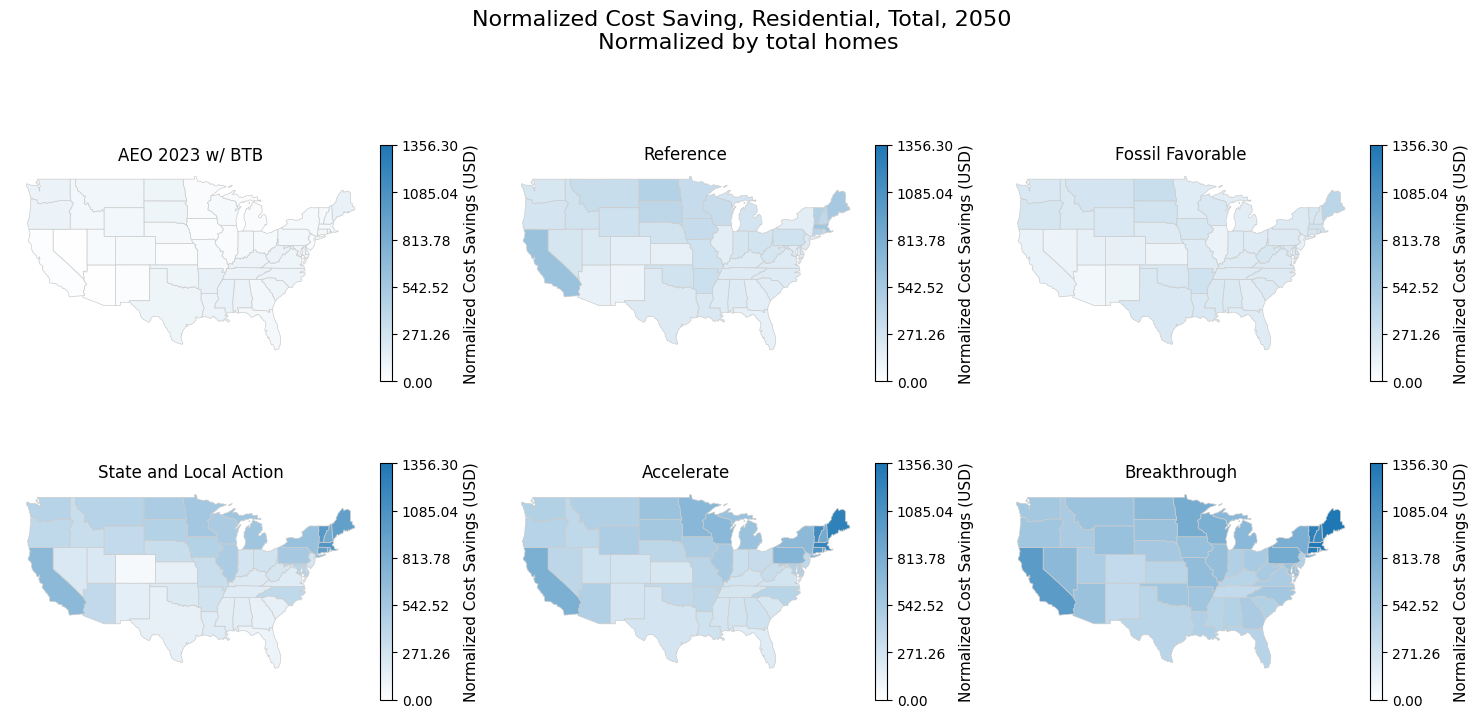

In [47]:
# state_cost_saving_merged is the normalized
# state_cost_saving is unormlaized
# sector = 'Residential' # Commercial, Residential
df_cost = state_cost_saving_merged
sector = 'Residential'
end_use_for_title = 'Total'
year = 2050
if sector =='All Sector':
    df_to_plot = df_cost[
        (df_cost['year'] ==year)
    ]
else:
    df_to_plot = df_cost[
        (df_cost['sector']==sector)&
        (df_cost['year'] ==year)
    ]
generate_map(df_to_plot, f'Normalized Cost Saving, {sector}, {end_use_for_title}, {year}', col_to_plot = 'cost_savings_normalized')

In [331]:
df_to_plot.head(2)

reg    scenario      sector           end_use  year         value  \
41   AL         AEO  Commercial  Cooling (Equip.)  2050  6.615816e+07   
279  AL  Accelerate  Commercial  Cooling (Equip.)  2050  4.544343e+07   

                     type  total house or sqft  cost_savings_normalized  
41   total square footage         1.564123e+09                 0.042297  
279  total square footage         1.564123e+09                 0.029054

In [ ]:
# by end use
# state_cost_saving_merged is the normalized
# state_cost_saving is unormlaized
# sector = 'Residential' # Commercial, Residential

end_use = 'Cooling (Equip.)' #'Heating (Equip.)'
end_use_for_title = end_use.replace(' (Equip.)', '')
print(end_use_for_title)

df_cost = state_cost_saving_merged[state_cost_saving_merged['end_use']==end_use]
sector = 'Residential'

year = 2050
if sector =='All Sector':
    df_to_plot = df_cost[
        (df_cost['year'] ==year)
    ]
else:
    df_to_plot = df_cost[
        (df_cost['sector']==sector)&
        (df_cost['year'] ==year)
    ]
generate_map(df_to_plot, f'Total Cost Saving, {sector}, {end_use_for_title}, {year}', col_to_plot = 'value')  #'cost_savings_normalized'/value

# Wedges (not in use)

## Sector scenarios - Heating / Cooling / Non mechanics

meas            adoption_scn                     metric  \
0  (R) Ref. Case Gas Dryer  Max adoption potential  Energy Cost Savings (USD)   
1  (R) Ref. Case Gas Dryer  Max adoption potential  Energy Cost Savings (USD)   

  reg          bldg_type end_use          fuel  year  value scenario  \
0  AL  Residential (New)   Other  Non-Electric  2024    0.0    ineff   
1  AL  Residential (New)   Other  Non-Electric  2025    0.0    ineff   

  measure_desc_simple  
0       Dryer, fossil  
1       Dryer, fossil

In [ ]:
def plot_enduses(combined_df, title):
    # Aggregate
    agg = combined_df.groupby(['scenario', 'sector', 'year','measure_desc_simple'])['value'].sum().reset_index()
    
    # Get unique values
    scenario_order = ['ref', 'ineff', 'stated', 'mid', 'high', 'breakthrough']
    
    # Filter to include only existing scenarios from the data
    scenarios = [s for s in scenario_order if s in agg['scenario'].unique()]
    sectors = ['Commercial', 'Residential']
    measures = sorted(agg['measure_desc_simple'].unique())
    # end_use_colors = {
    #     'Computers and Electronics': 'brown',
    #     'Cooking': 'mistyrose',
    #     'Cooling (Equip.)': 'tab:blue',
    #     'Heating (Equip.)': 'tab:red',
    #     'Lighting': 'tab:green',
    #     'Other': 'honeydew',
    #     'Refrigeration': 'darkviolet',
    #     'Ventilation': 'lavender',
    #     'Water Heating': 'tab:orange'
    # }
    cmap = cm.get_cmap('Set1', len(measures))
    meas_colors = {m: mcolors.to_hex(cmap(i)) for i, m in enumerate(measures)}
    # Create subplots
    fig, axes = plt.subplots(nrows=2, ncols=len(scenarios), figsize=(3*len(scenarios), 6), sharey=True)
    
    for i, sector in enumerate(sectors):
        for j, scenario in enumerate(scenarios):
            ax = axes[i][j] if len(scenarios) > 1 else axes[i]

            data = agg[(agg['sector'] == sector) & (agg['scenario'] == scenario)]
            pivot = data.pivot(index='year', columns='measure_desc_simple', values='value').fillna(0)
            pivot = pivot[[m for m in measures if m in pivot.columns]]

            ax.stackplot(pivot.index, pivot.T, labels=pivot.columns, colors=[meas_colors[m] for m in pivot.columns])

            ax.set_title(scenario, fontsize=12)
            if j == 0:
                ax.set_ylabel(f"{sector}\nTotal Cost (USD Billions)", fontsize=11)
            else:
                ax.set_yticklabels([])

            ax.set_xlim(pivot.index.min(), pivot.index.max())
            ax.set_xticks([2030, 2040, 2050])
            ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x / 1e9:,.0f}'))

    
    
    # Legend
    handles = [plt.Rectangle((0, 0), 1, 1, color=meas_colors[m]) for m in measures]
    fig.legend(
        handles, measures,
        loc='upper center',
        bbox_to_anchor=(0.5, -0.08),
        ncol=3, fontsize=9
    )
    fig.suptitle(f"Total Cost by Measure for {title}", fontsize=16, y=1)
    plt.tight_layout()
    # plt.savefig(f'cost_graph_operational/total_cost_{title}_sector_scenario.png', transparent=True, bbox_inches='tight')

## Sector scenarios

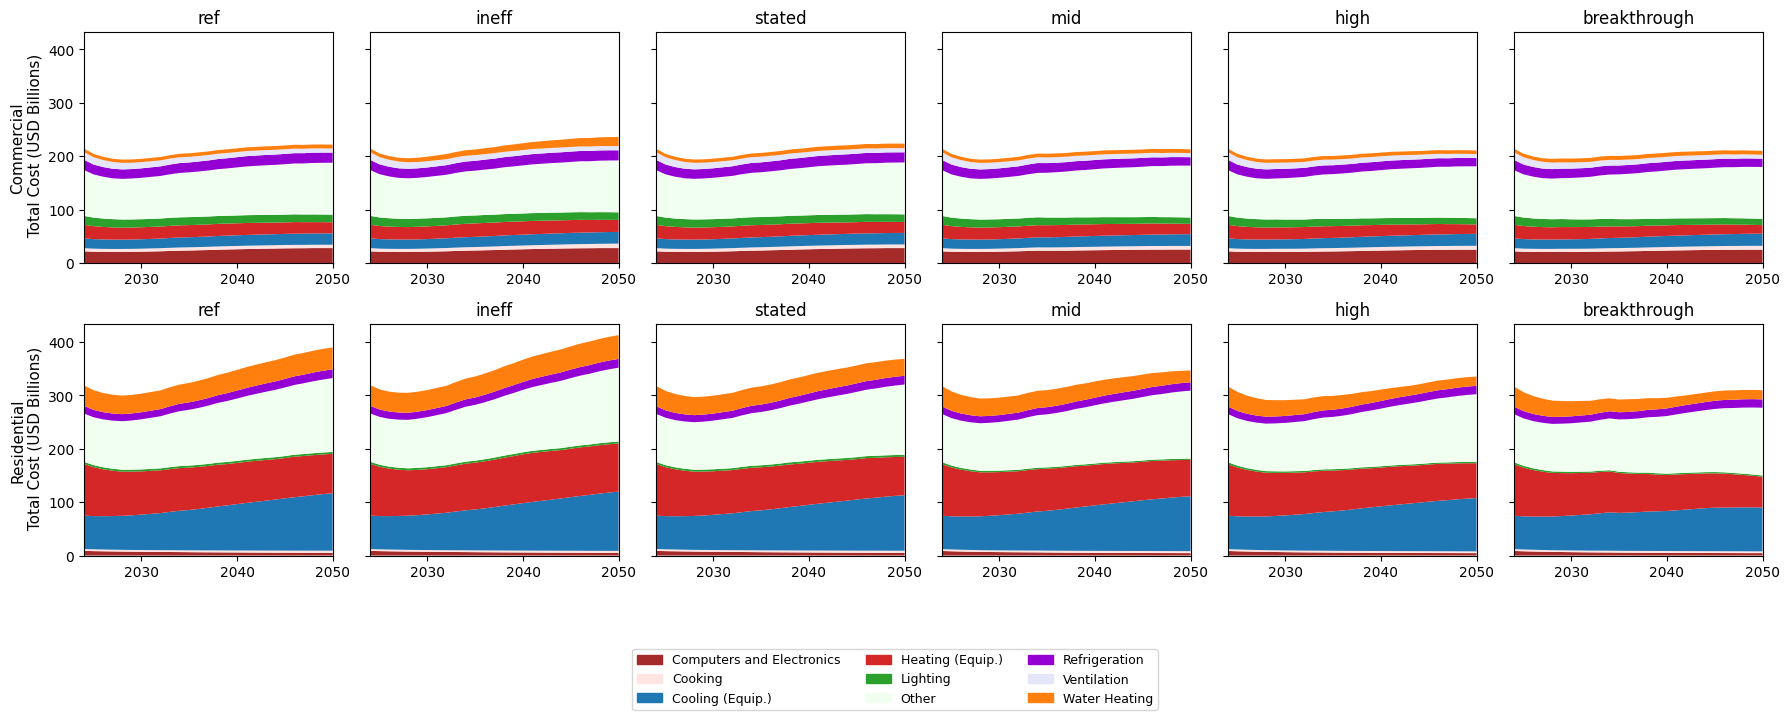

In [ ]:


# Aggregate
agg = combined_df.groupby(['scenario', 'sector', 'year', 'end_use'])['value'].sum().reset_index()

# Get unique values
scenario_order = ['ref', 'ineff', 'stated', 'mid', 'high', 'breakthrough']

# Filter to include only existing scenarios from the data
scenarios = [s for s in scenario_order if s in agg['scenario'].unique()]
sectors = ['Commercial', 'Residential']
end_uses = sorted(agg['end_use'].unique())
end_use_colors = {
    'Computers and Electronics': 'brown',
    'Cooking': 'mistyrose',
    'Cooling (Equip.)': 'tab:blue',
    'Heating (Equip.)': 'tab:red',
    'Lighting': 'tab:green',
    'Other': 'honeydew',
    'Refrigeration': 'darkviolet',
    'Ventilation': 'lavender',
    'Water Heating': 'tab:orange'
}

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=len(scenarios), figsize=(3*len(scenarios), 6), sharey=True)

# Plot
for i, sector in enumerate(sectors):
    for j, scenario in enumerate(scenarios):
        ax = axes[i][j] if len(scenarios) > 1 else axes[i]

        # Filter and pivot
        data = agg[(agg['sector'] == sector) & (agg['scenario'] == scenario)]
        pivot = data.pivot(index='year', columns='end_use', values='value').fillna(0)

        # Reorder columns to match color assignment
        pivot = pivot[[eu for eu in end_uses if eu in pivot.columns]]

        # Plot stacked area
        ax.stackplot(pivot.index, pivot.T, labels=pivot.columns, colors=[end_use_colors[eu] for eu in pivot.columns])

        ax.set_title(scenario, fontsize=12)
        if j == 0:
            ax.set_ylabel(f"{sector}\n Total Cost (USD Billions)", fontsize=11)
        else:
            ax.set_yticklabels([])

        ax.set_xlim(pivot.index.min(), pivot.index.max())
        ax.set_xticks([2030, 2040, 2050])
        ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x / 1e9:,.0f}'))


# Legend
handles = [plt.Rectangle((0, 0), 1, 1, color=end_use_colors[eu]) for eu in end_uses if eu in end_use_colors]
labels = [eu for eu in end_uses if eu in end_use_colors]
fig.legend(
    handles, end_uses,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.08),  # Adjust as needed
    ncol=3, fontsize=9
)
title = 'Annual Total Cost by Scenarios and Sectors'
plt.tight_layout()
# plt.savefig(f'cost_graph_operational/{title}_sector_scenario.png', transparent=True, bbox_inches='tight')


C:\Users\vapeu\AppData\Local\Temp\ipykernel_12468\3674983448.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Set1', len(measures))


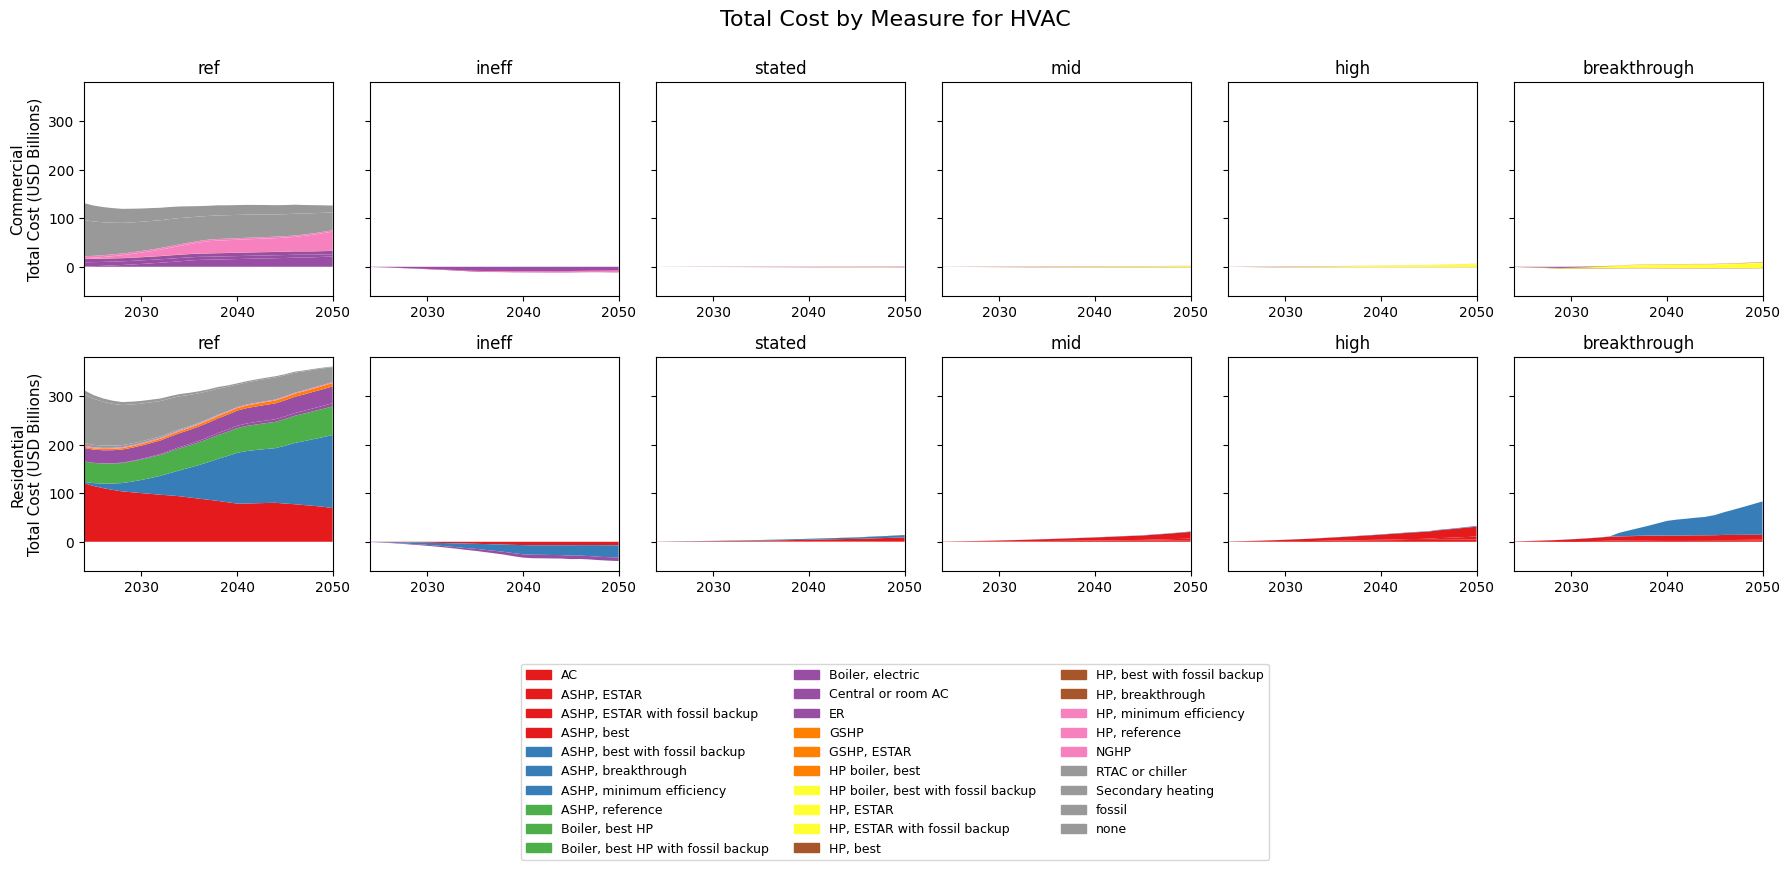

In [20]:
combined_df_hvac = combined_df[combined_df['end_use'].isin(['Heating (Equip.)', 'Cooling (Equip.)'])]
plot_enduses(combined_df_hvac, 'HVAC')

C:\Users\vapeu\AppData\Local\Temp\ipykernel_12468\3674983448.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Set1', len(measures))


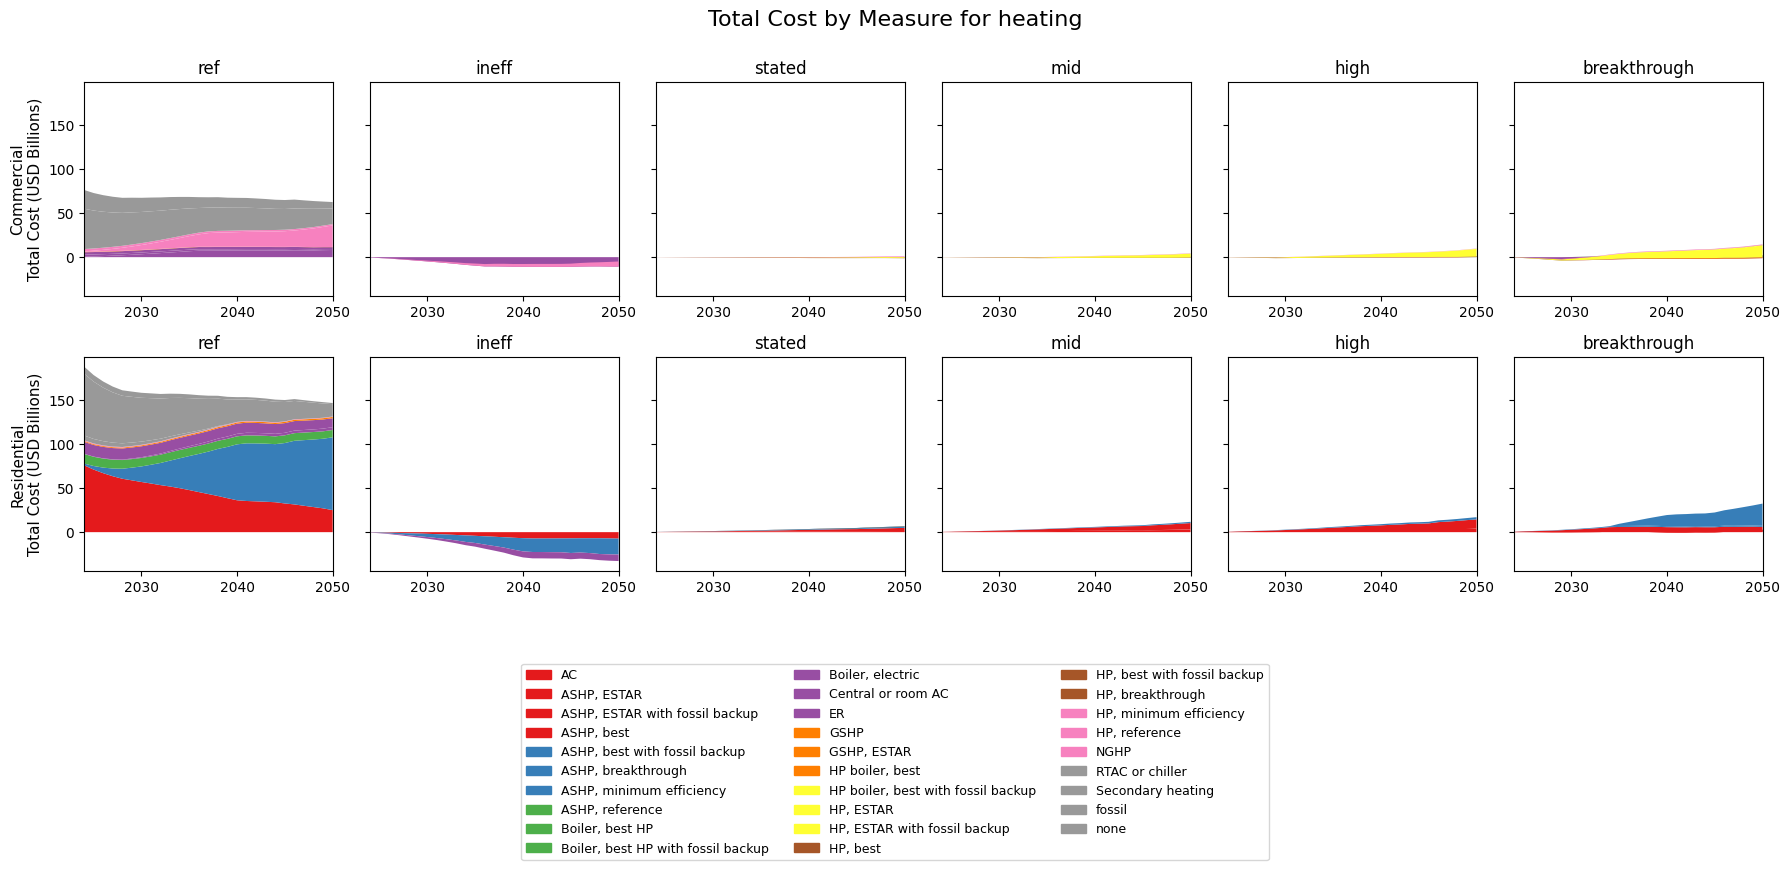

In [21]:
combined_df_heating = combined_df[combined_df['end_use'].isin(['Heating (Equip.)'])]
plot_enduses(combined_df_heating, 'heating')

C:\Users\vapeu\AppData\Local\Temp\ipykernel_12468\3674983448.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Set1', len(measures))


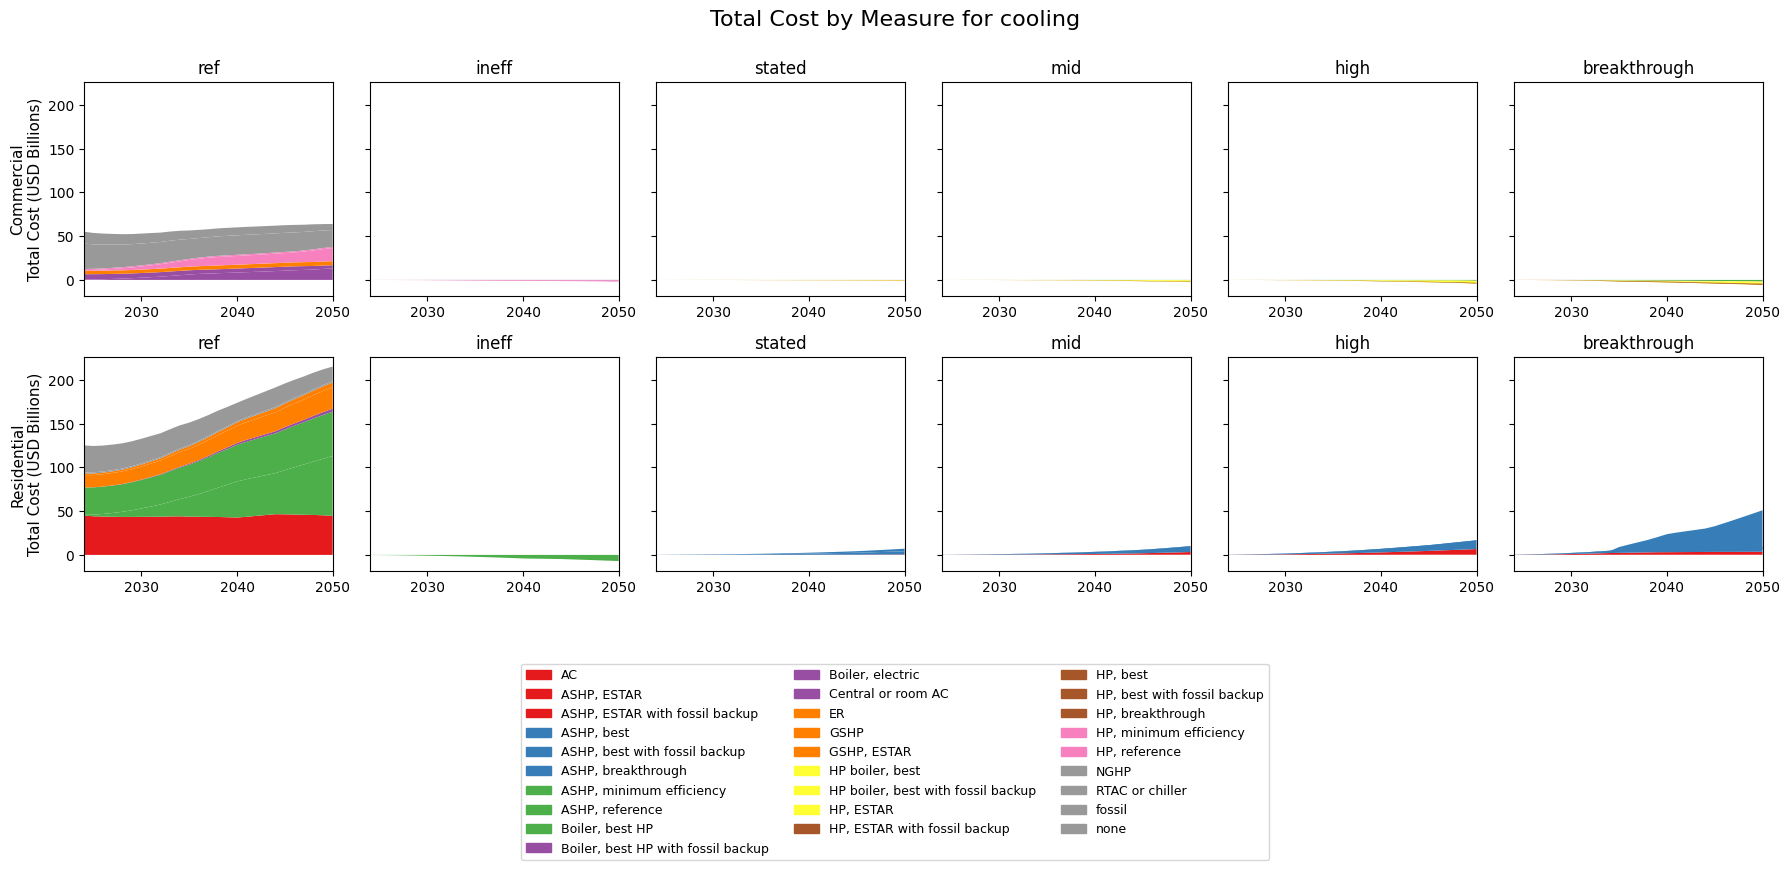

In [22]:
combined_df_heating = combined_df[combined_df['end_use'].isin(['Cooling (Equip.)'])]
plot_enduses(combined_df_heating, 'cooling')

C:\Users\vapeu\AppData\Local\Temp\ipykernel_10896\3005769342.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Set1', len(measures))


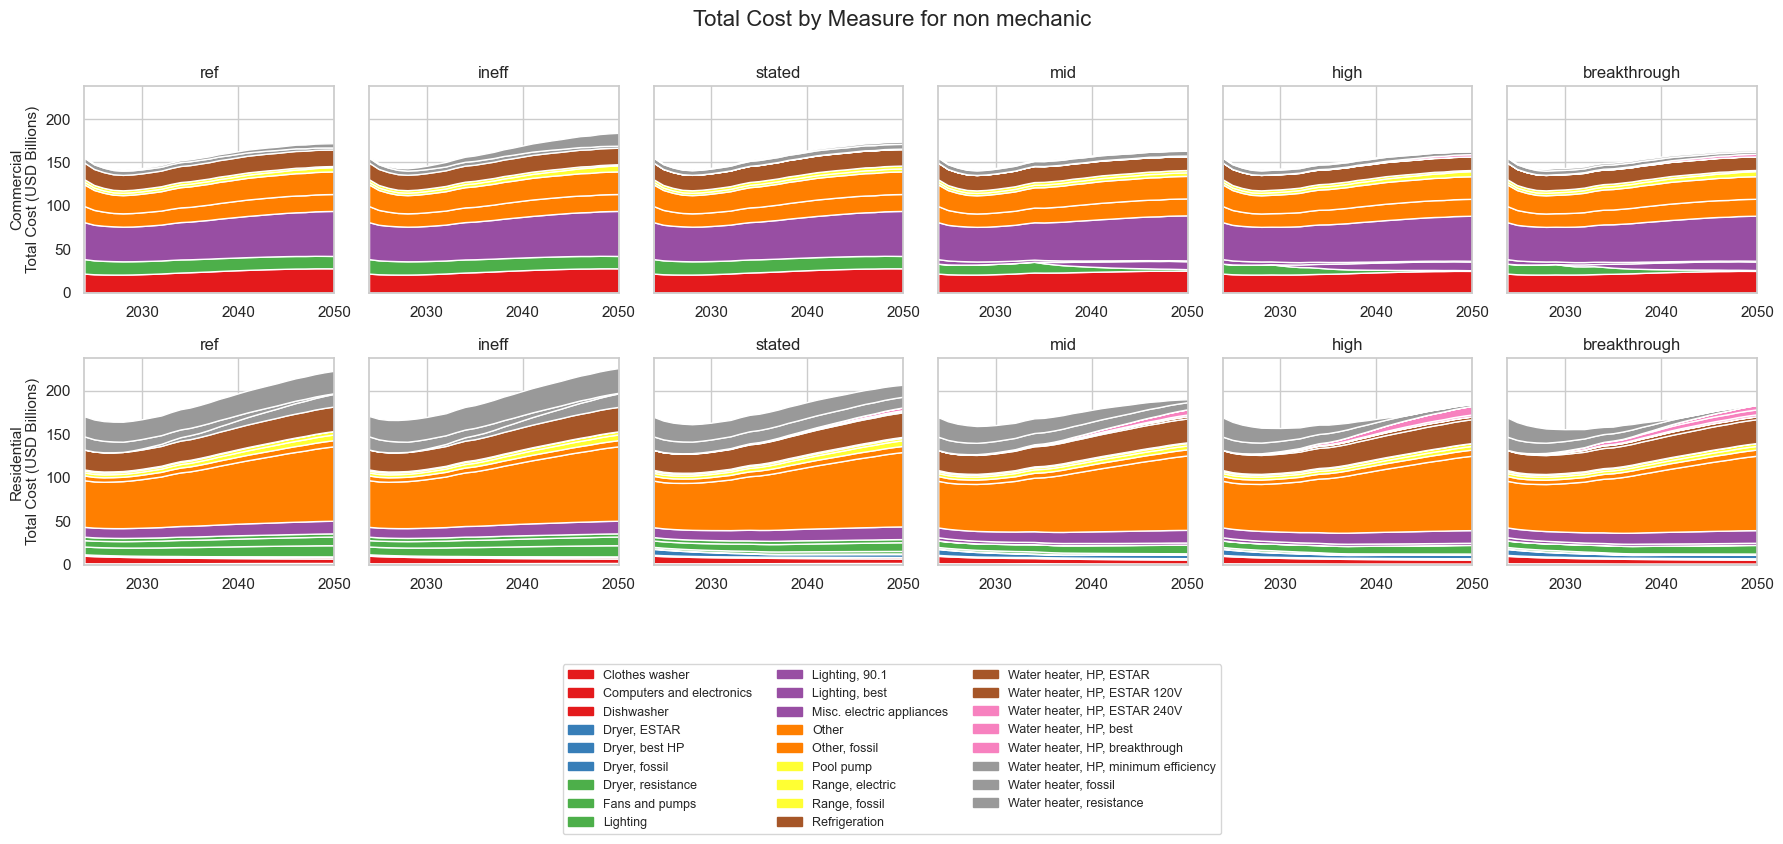

In [180]:
combined_df_non_mechanic = combined_df[~combined_df['end_use'].isin(['Heating (Equip.)', 'Cooling (Equip.)', 'Ventilation'])]
plot_enduses(combined_df_non_mechanic, 'non mechanic')

## State wedges

In [ ]:
def plot_enduses_by_states( combined_df, selected_states, title):
    df_filtered = combined_df[combined_df['reg'].isin(selected_states)].copy()

    # Simplify to 'Residential' or 'Commercial'
    df_filtered['sector'] = df_filtered['bldg_type'].str.extract(r'(Residential|Commercial)')

    # Aggregate by state
    agg = df_filtered.groupby(['reg', 'scenario', 'year', 'measure_desc_simple'])['value'].sum().reset_index()

    # Scenario and measure order
    scenario_order = ['ref', 'ineff', 'stated', 'mid', 'high', 'breakthrough']
    scenarios = [s for s in scenario_order if s in agg['scenario'].unique()]
    measures = sorted(agg['measure_desc_simple'].unique())

    # Assign colors
    cmap = cm.get_cmap('Set1', len(measures))
    meas_colors = {m: mcolors.to_hex(cmap(i)) for i, m in enumerate(measures)}

    # Plot: rows = states, cols = scenarios
    fig, axes = plt.subplots(nrows=len(selected_states), ncols=len(scenarios), figsize=(4*len(scenarios), 3*len(selected_states)), sharex=True)

    for i, state in enumerate(selected_states):
        for j, scenario in enumerate(scenarios):
            ax = axes[i][j] if len(scenarios) > 1 else axes[i]

            data = agg[(agg['reg'] == state) & (agg['scenario'] == scenario)]
            pivot = data.pivot(index='year', columns='measure_desc_simple', values='value').fillna(0)
            pivot = pivot[[m for m in measures if m in pivot.columns]]

            ax.stackplot(pivot.index, pivot.T, labels=pivot.columns, colors=[meas_colors[m] for m in pivot.columns])
            ax.set_xlim(pivot.index.min(), pivot.index.max())
            ax.set_xticks([2030, 2040, 2050])
            ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x / 1e6:,.0f}'))

            if j == 0:
                ax.set_ylabel(state, fontsize=12)
            else:
                ax.set_yticklabels([])

            if i == 0:
                ax.set_title(scenario.capitalize(), fontsize=12)

    # Legend
    handles = [plt.Rectangle((0, 0), 1, 1, color=meas_colors[m]) for m in measures]
    fig.legend(
        handles, measures,
        loc='upper center',
        bbox_to_anchor=(0.5, 0),
        ncol=3, fontsize=9
    )
    fig.suptitle(f"Technology Composition by State – {title}", fontsize=16, y=1.02)
    plt.tight_layout(rect=[0, 0, 0.88, 1])
    plt.savefig(f'cost_graph_operational/tech_composition_{title}_by_state.png', transparent=True, bbox_inches='tight')

C:\Users\vapeu\AppData\Local\Temp\ipykernel_10896\303169120.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Set1', len(measures))


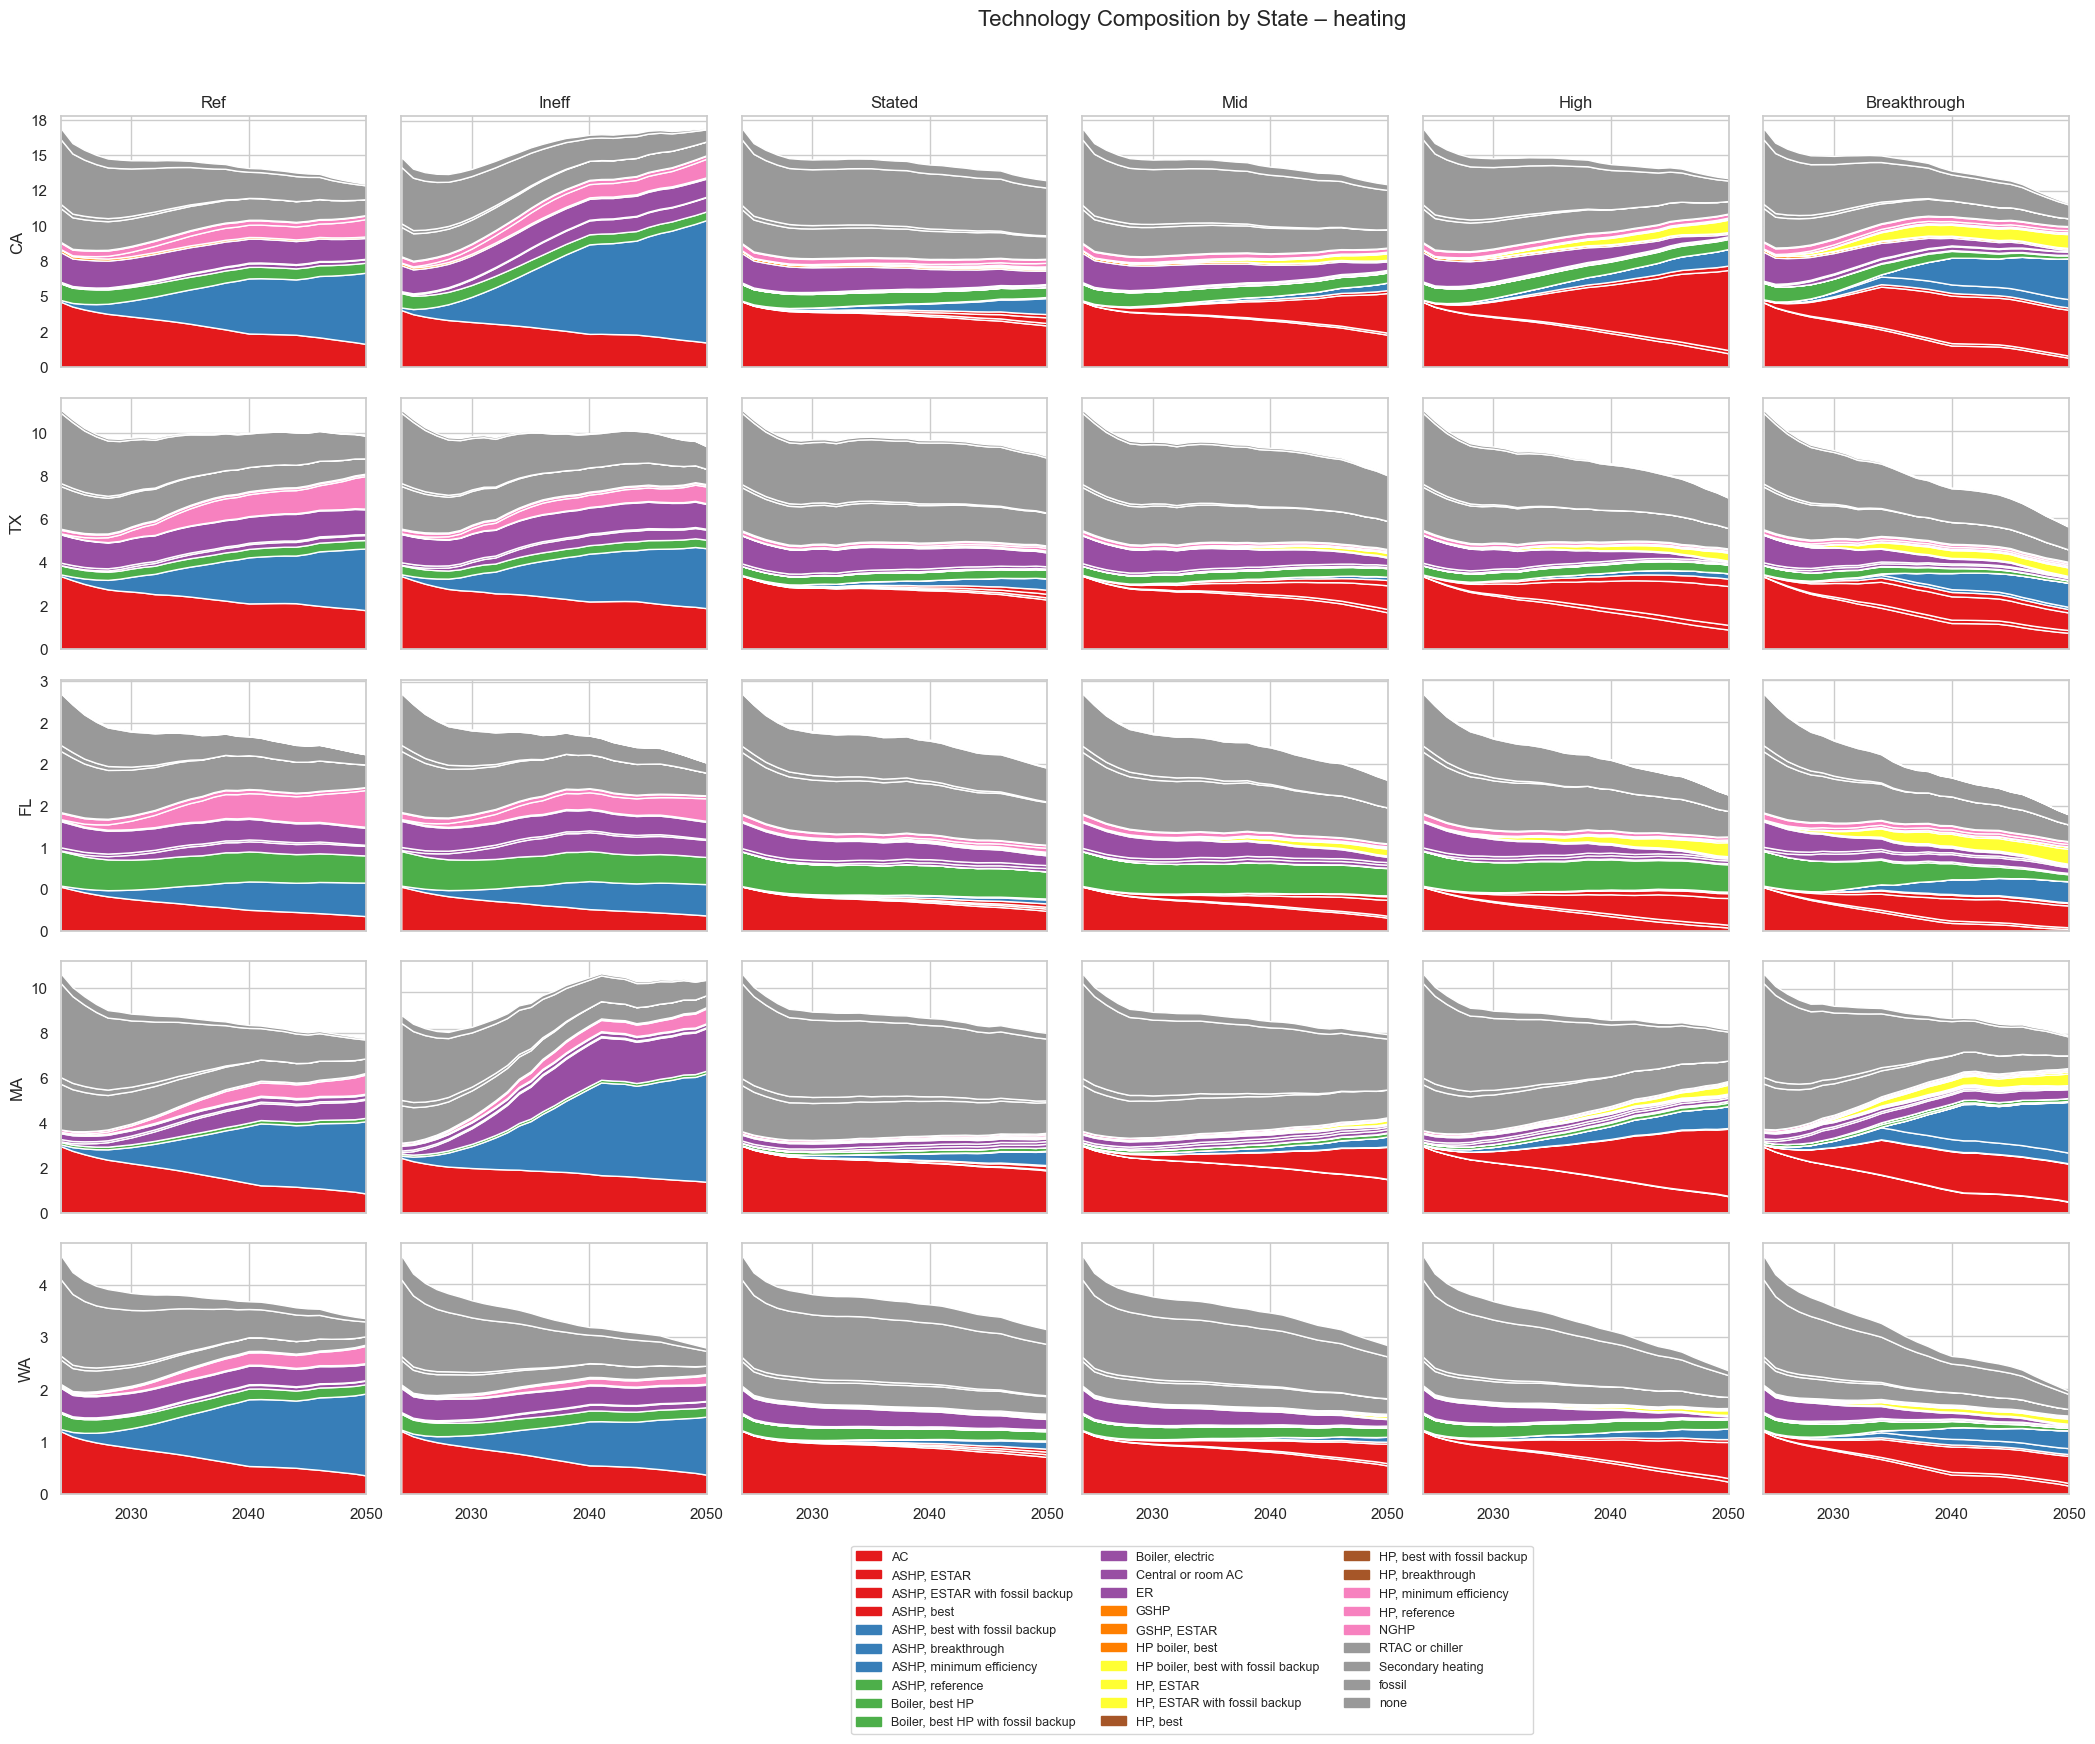

In [265]:
heating_states = ['CA', 'TX', 'FL', 'MA', 'WA']
combined_df_heating = combined_df[combined_df['end_use'].isin(['Heating (Equip.)'])]
plot_enduses_by_states(combined_df_heating,  heating_states,  'heating')

C:\Users\vapeu\AppData\Local\Temp\ipykernel_10896\303169120.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Set1', len(measures))


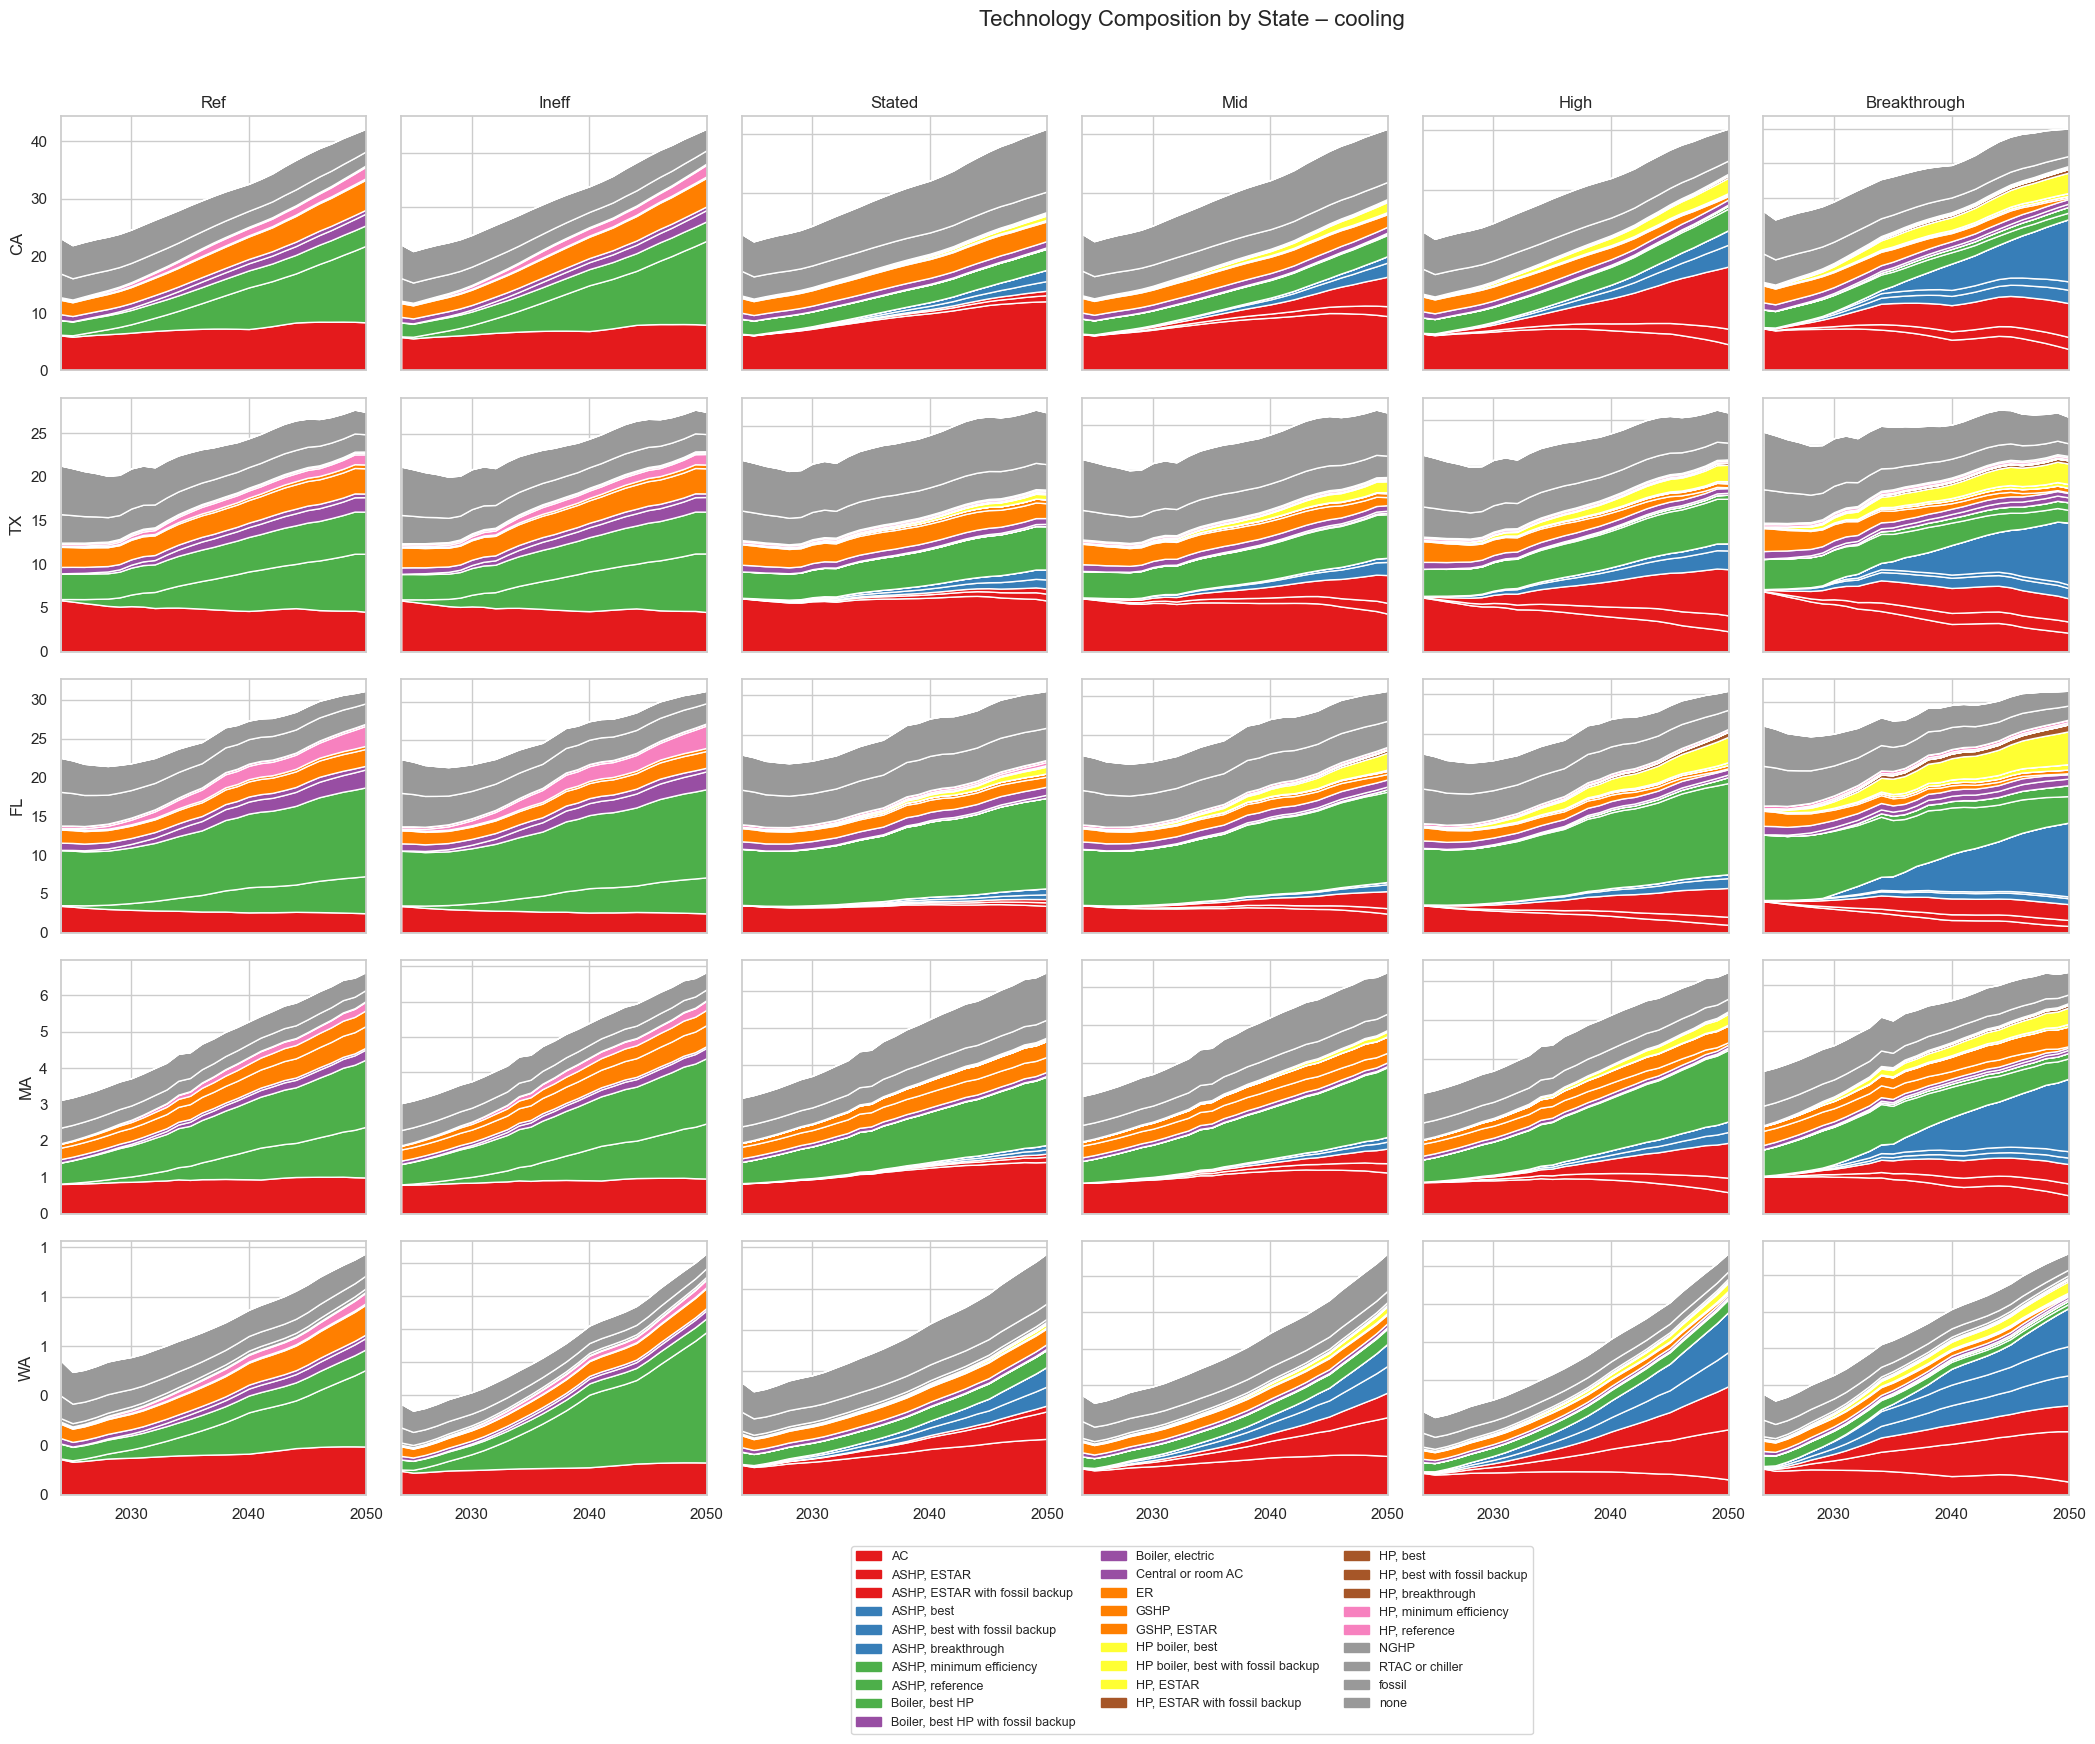

In [266]:
cooling_states = ['CA', 'TX', 'FL', 'MA', 'WA']
combined_df_cooling = combined_df[combined_df['end_use'].isin(['Cooling (Equip.)'])]
plot_enduses_by_states(combined_df_cooling,  cooling_states,  'cooling')

In [268]:
combined_df_heating_saving = combined_df_heating_saving.merge(
    measure_map[['meas', 'measure_desc_simple']],
    on='meas',
    how='left'
)
combined_df_cooling_saving = combined_df_cooling_saving.merge(
    measure_map[['meas', 'measure_desc_simple']],
    on='meas',
    how='left'
)

C:\Users\vapeu\AppData\Local\Temp\ipykernel_10896\3547548738.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Set1', len(measures))


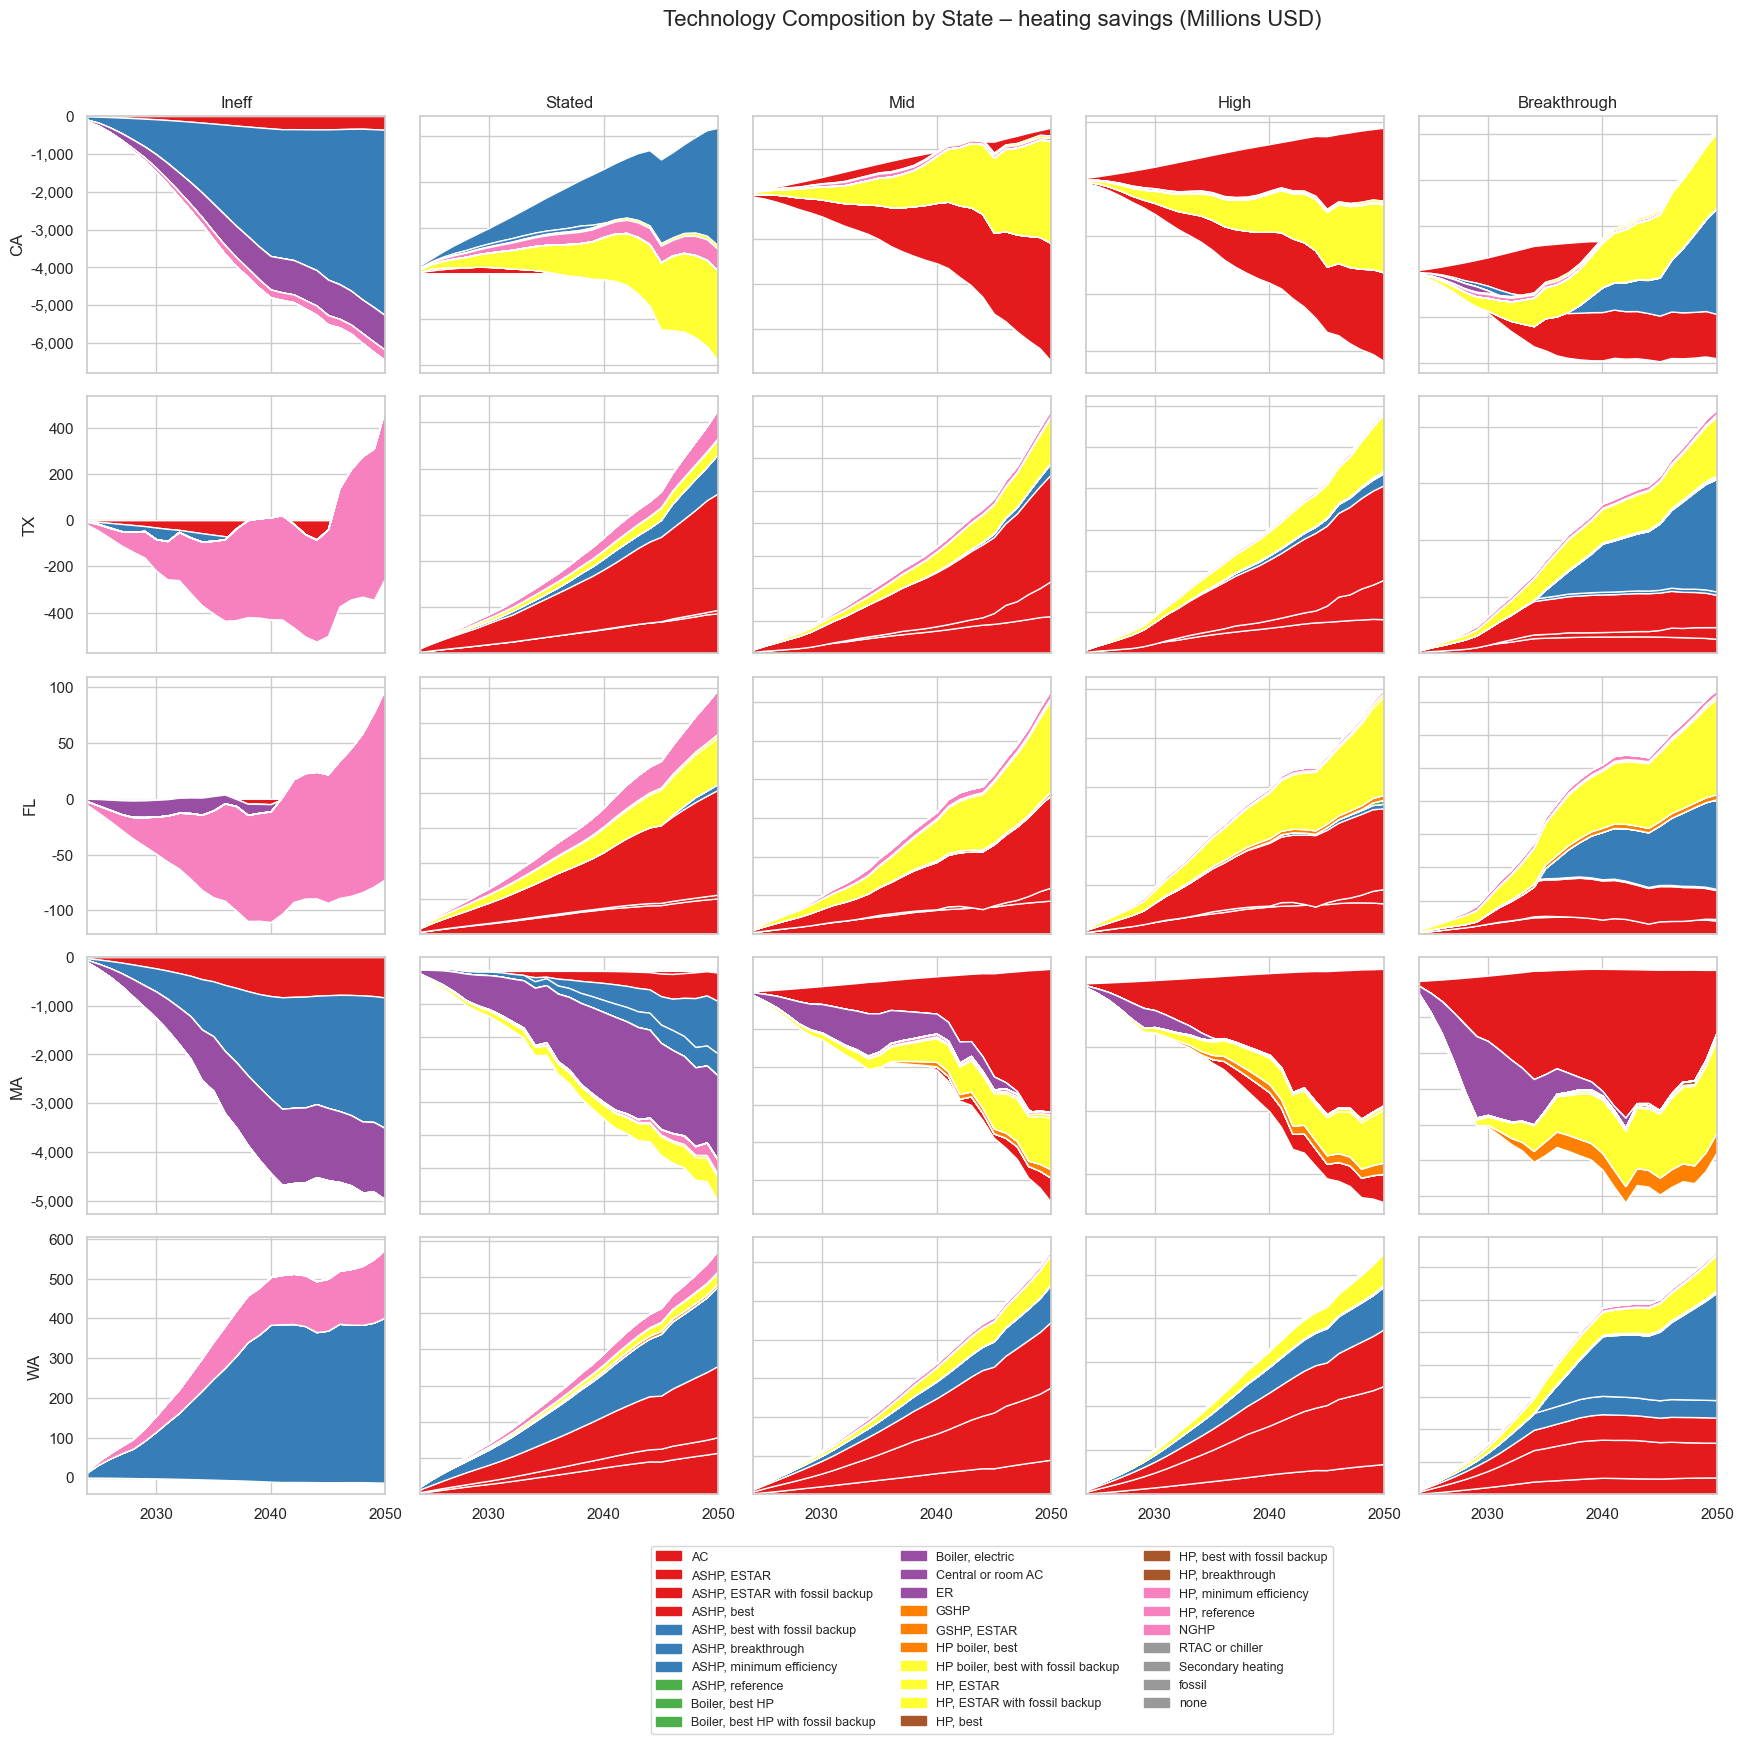

In [277]:
plot_enduses_by_states(combined_df_heating_saving,  heating_states,  'heating savings (Millions USD)')

C:\Users\vapeu\AppData\Local\Temp\ipykernel_10896\3547548738.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Set1', len(measures))


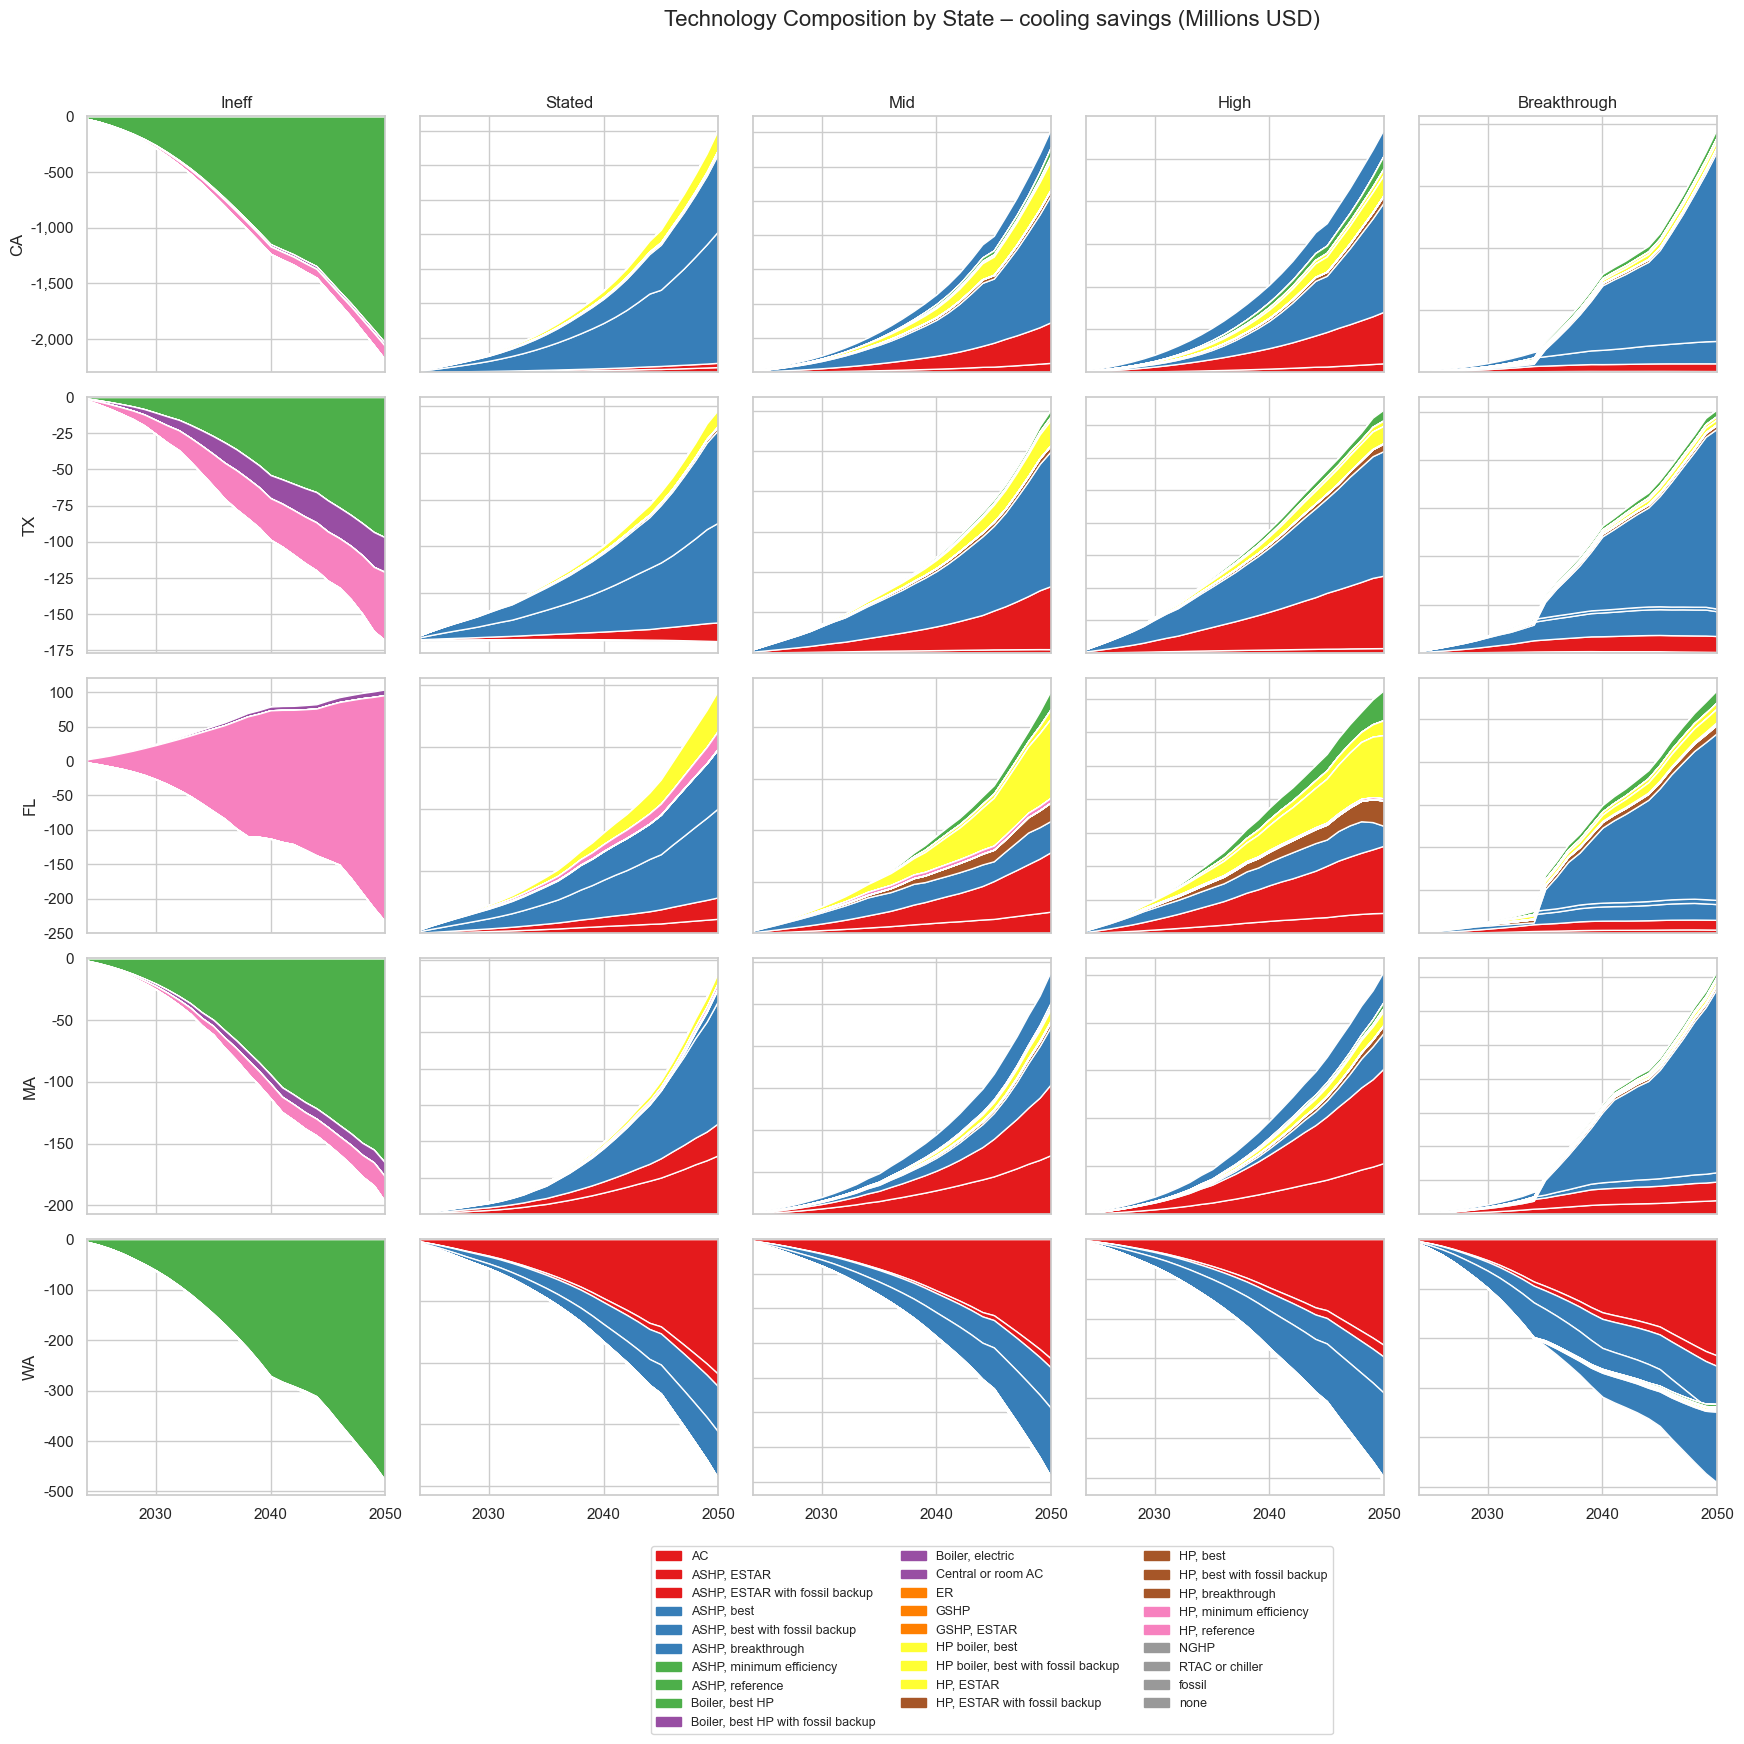

In [278]:
plot_enduses_by_states(combined_df_cooling_saving,  cooling_states,  'cooling savings (Millions USD)')